In [1]:
# @title 1. Install and Import Dependencies
print("Cell 1: Installed MuJoCo + mediapy, imported all required libraries, and selected the EGL backend for rendering.")
!pip install mujoco mediapy

import os
import csv
import matplotlib.pyplot as plt
import numpy as np

# Set MuJoCo rendering backend (needed for Colab)
if 'COLAB_GPU' in os.environ:
    os.environ['MUJOCO_GL'] = 'egl'
else:
    os.environ['MUJOCO_GL'] = 'egl'

import mujoco
import mediapy as media




Cell 1: Installed MuJoCo + mediapy, imported all required libraries, and selected the EGL backend for rendering.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.1 MB/s eta 0:00:00


In [2]:
# @title 2. Define Simulation Parameters and Motor Model
print("Cell 2: Defined all gait parameters and implemented a DC-motor-based torque model used to drive the joints.")
# --- GAIT / MOTION CONFIGURATION ---
start_angle_A2 = -80
end_angle_A2   = -160

start_angle_B1 = -70
end_angle_B1   = -130

duration    = 7.0      # total simulation time [s]
framerate   = 60       # video FPS
speed       = 10.0     # oscillation speed
phase_offset = 1.57    # phase offset between the two legs [rad] (4 different value: pi/2 for first 2 observations, pi/4, 3pi/4, pi)

# Sinusoid midpoints and amplitudes (deg)
mid_A2 = (start_angle_A2 + end_angle_A2) / 2
amp_A2 = (start_angle_A2 - end_angle_A2) / 2

mid_B1 = (start_angle_B1 + end_angle_B1) / 2
amp_B1 = (start_angle_B1 - end_angle_B1) / 2

# Threshold for detecting foot-ground contact (for gait analysis)
contact_threshold = 0.02  # [m]


# --- MOTOR / SERVO PHYSICS (simple DC motor model) ---
Vnom          = 6.0      # nominal motor voltage [V]
G             = 55.5     # gear ratio
i_stall       = 0.6      # stall current [A]
t_stall_motor = 0.15     # stall torque at motor shaft [Nm]
w_nl_deg      = 0.66 * 1000  # no-load speed [deg/s]

R    = Vnom / i_stall                 # winding resistance [Ohm]
w_nl = w_nl_deg * (np.pi / 180.0)     # no-load speed [rad/s]
kt   = t_stall_motor / i_stall        # torque constant [Nm/A]
ke   = kt                             # back-EMF constant (SI)
b_motor = (kt * i_stall) / (w_nl * G) # viscous friction (approx)
V_supply = 12.0                       # supply voltage [V]
kp_motor = 50.0                       # position gain for servo control


def calculate_real_torque(current_q, current_vel, desired_q):
    """DC motor model with simple position control -> joint torque."""
    error = desired_q - current_q
    V = kp_motor * error

    # Saturate voltage to supply
    if V > V_supply:
        V = V_supply
    if V < -V_supply:
        V = -V_supply

    # Motor-side angular velocity
    w_motor = current_vel * G

    # Motor current from electrical model
    current = (V - (ke * w_motor)) / R

    # Motor shaft torque with viscous losses
    torque_motor = (kt * current) - (b_motor * w_motor)

    # Return joint torque after gearbox
    return torque_motor * G
    print("Cell 2: Defined all gait parameters and implemented a DC-motor-based torque model used to drive the joints.")


Cell 2: Defined all gait parameters and implemented a DC-motor-based torque model used to drive the joints.


In [3]:
# @title xml model
print("Cell 3: Defined the full MuJoCo MJCF model (rigid body, legs, foot, loop constraint, and camera) as an XML string.")
mjcf_xml = """
<mujoco model="5_bar_pendulum_scaled">
  <option timestep="0.002" gravity="0 0 -9.81" integrator="RK4" solver="Newton" iterations="100" tolerance="1e-4"/>

  <visual>
    <global offwidth="640" offheight="480"/>
    <rgba haze="1 1 1 1"/> <headlight active="1" diffuse="0.8 0.8 0.8"/>
  </visual>

  <asset>
     <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".8 .9 .9"/>
     <material name="grid_mat" texture="grid" texrepeat="1 1" texuniform="true" reflectance=".2"/>
  </asset>

  <default>
    <geom type="capsule" size="0.005" density="1000"/>
    <joint damping="5.0" armature="0.2"/>
  </default>

  <worldbody>
    <geom name="floor" type="plane" size="5 1 0.1" material="grid_mat" friction="2.0 0.005 0.0001"/>

    <body name="Rig" pos="0 0 0.5">
      <joint name="x_rail" type="slide" axis="1 0 0" damping="0.5"/>
      <joint name="z_bounce" type="slide" axis="0 0 1" damping="2.0" stiffness="0"/>

      <geom type="box" pos="0.15625 0 0" size="0.15625 0.01 0.01" rgba="0.2 0.2 0.2 1" mass="3"/>

      <geom name="stand_rear" type="capsule" fromto="0 0 0 0 0 -0.1875" size="0.01" rgba="0.5 0.5 0.5 0.3" friction="0 0 0"/>
      <geom name="stand_front" type="capsule" fromto="0.15625 0 0 0.15625 0 -0.1875" size="0.01" rgba="0.5 0.5 0.5 0.3" friction="0 0 0"/>

      <body name="A2" pos="0.25 0 0" euler="180 0 0">
        <joint name="qA2" axis="0 1 0"/>
        <geom fromto="0 0 0 0.0625 0 0" rgba="0.2 0.2 0.8 1"/>
        <body name="B2" pos="0.0625 0 0">
          <joint name="qB2" axis="0 1 0"/>
          <geom fromto="0 0 0 0.0625 0 0" rgba="0.2 0.8 0.8 1"/>
          <site name="s_B2_tip" pos="0.0625 0 0" size="0.005" rgba="0 0 0 0"/>
          <geom fromto="0.0625 0 0 0.1291 0 0" rgba="0 0.8 0 1"/>
          <body name="A32" pos="0.1291 0 0">
              <joint name="qA32" axis="0 1 0" stiffness="500" damping="10"/>
              <geom fromto="0 0 0 0.0333 0 0" rgba="0 1 0 1"/>
              <geom name="foot" type="sphere" pos="0.0333 0 0" size="0.01" friction="100"/>
              <site name="green_tip" pos="0.0333 0 0" size="0.008" rgba="1 0 0 1"/>
          </body>
        </body>
      </body>

      <body name="B1" pos="0.3125 0 0" euler="180 0 0">
        <joint name="qB1" axis="0 1 0"/>
        <geom fromto="0 0 0 0.0625 0 0" rgba="0.8 0.2 0.2 1"/>
        <body name="C1" pos="0.0625 0 0">
          <joint name="qC1" axis="0 1 0"/>
          <geom fromto="0 0 0 0.0625 0 0" rgba="0.8 0.2 0.8 1"/>
          <site name="s_C1_tip" pos="0.0625 0 0" size="0.005" rgba="0 0 0 0"/>
        </body>
      </body>
    </body>

    <camera name="track_cam" mode="track" target="Rig" pos="0.3 -1.5 0.5" xyaxes="1 0 0 0 0 1"/>
  </worldbody>

  <equality>
    <connect name="loop_closure" site1="s_B2_tip" site2="s_C1_tip"/>
  </equality>

  <actuator>
    <motor name="servo_A2" joint="qA2" gear="1"/>
    <motor name="servo_B1" joint="qB1" gear="1"/>
  </actuator>

</mujoco>"""

Cell 3: Defined the full MuJoCo MJCF model (rigid body, legs, foot, loop constraint, and camera) as an XML string.


In [4]:
# @title 4. Run Simulation and Generate Video Frames
print("Cell 4: Built the model, ran warmup + main simulation, logged kinematics and energy, rendered frames, computed gait stats, and saved frames to a video file.")
# Build model and data
model = mujoco.MjModel.from_xml_string(mjcf_xml)
data = mujoco.MjData(model)
mujoco.mj_resetData(model, data)

# Simulation timestep from model
dt = model.opt.timestep

# Joint indices / addresses
qA2_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'qA2')
qB1_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'qB1')

qA2_adr   = model.jnt_qposadr[qA2_id]
qB1_adr   = model.jnt_qposadr[qB1_id]
dofA2_adr = model.jnt_dofadr[qA2_id]
dofB1_adr = model.jnt_dofadr[qB1_id]

# Initial joint configuration
data.qpos[qA2_adr] = np.deg2rad(start_angle_A2)
data.qpos[qB1_adr] = np.deg2rad(start_angle_B1)

# --- WARMUP / SETTLING PHASE ---
print("Settling physics (Warmup)...")
for _ in range(200):
    curr_qA2 = data.qpos[qA2_adr]
    curr_wA2 = data.qvel[dofA2_adr]
    trq_A = calculate_real_torque(curr_qA2, curr_wA2, np.deg2rad(start_angle_A2))

    curr_qB1 = data.qpos[qB1_adr]
    curr_wB1 = data.qvel[dofB1_adr]
    trq_B = calculate_real_torque(curr_qB1, curr_wB1, np.deg2rad(start_angle_B1))

    data.ctrl[0] = trq_A
    data.ctrl[1] = trq_B
    mujoco.mj_step(model, data)

data.qvel[:] = 0.0
print("Physics settled. Starting simulation...")

# --- PREPARE LOGGING & RENDERING ---
green_tip_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, 'green_tip')
renderer = mujoco.Renderer(model, height=480, width=640)

times        = []
x_positions  = []
z_positions  = []
velocities   = []

energy_potential = []   # potential energy
energy_kinetic   = []   # kinetic energy
energy_total     = []   # total mechanical energy

frames = []

# --- MAIN SIMULATION LOOP ---
while data.time < duration:
    # Oscillatory target angles (deg)
    target_A2_deg = mid_A2 + amp_A2 * np.cos(speed * data.time)
    target_B1_deg = mid_B1 + amp_B1 * np.cos(speed * data.time + phase_offset)

    # Convert to radians
    target_A2 = np.deg2rad(target_A2_deg)
    target_B1 = np.deg2rad(target_B1_deg)

    # Current state
    curr_qA2 = data.qpos[qA2_adr]
    curr_wA2 = data.qvel[dofA2_adr]
    curr_qB1 = data.qpos[qB1_adr]
    curr_wB1 = data.qvel[dofB1_adr]

    # Motor torques
    torque_A = calculate_real_torque(curr_qA2, curr_wA2, target_A2)
    torque_B = calculate_real_torque(curr_qB1, curr_wB1, target_B1)

    data.ctrl[0] = torque_A
    data.ctrl[1] = torque_B

    # Advance physics
    mujoco.mj_step(model, data)

    # --- KINEMATICS LOGGING (end-effector) ---
    pos = data.site_xpos[green_tip_id]  # [x, y, z] of green_tip
    if len(x_positions) > 0:
        vel = (pos[0] - x_positions[-1]) / dt
    else:
        vel = 0.0

    times.append(data.time)
    x_positions.append(pos[0])
    z_positions.append(pos[2])
    velocities.append(vel)

    # --- ENERGY LOGGING ---
    # Compute potential and kinetic energy into data.energy[0], data.energy[1]
    mujoco.mj_energyPos(model, data)
    mujoco.mj_energyVel(model, data)
    energy_potential.append(float(data.energy[0]))            # potential
    energy_kinetic.append(float(data.energy[1]))              # kinetic
    energy_total.append(float(data.energy[0] + data.energy[1]))  # total

    # --- RENDER VIDEO FRAMES ---
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, camera="track_cam")
        frames.append(renderer.render())

print(f"Simulation complete. Generated {len(frames)} frames and {len(times)} time samples.")

# --- GAIT STATS (STRIDE LENGTH) ---
contacts = []
for i in range(1, len(z_positions)):
    if z_positions[i-1] > contact_threshold and z_positions[i] <= contact_threshold:
        contacts.append(i)

print("\n--- GAIT ANALYSIS ---")
if len(contacts) > 1:
    total_dist = 0.0
    for i in range(len(contacts) - 1):
        idx_now  = contacts[i]
        idx_next = contacts[i+1]
        stride_len = x_positions[idx_next] - x_positions[idx_now]
        print(f"Stride {i+1}: Length = {stride_len:.3f} m")
        total_dist += stride_len
    print(f"Average Stride Length: {total_dist / (len(contacts) - 1):.3f} m")
else:
    print("Not enough contacts detected to compute stride length.")




Cell 4: Built the model, ran warmup + main simulation, logged kinematics and energy, rendered frames, computed gait stats, and saved frames to a video file.
Settling physics (Warmup)...
Physics settled. Starting simulation...
Simulation complete. Generated 421 frames and 3301 time samples.

--- GAIT ANALYSIS ---
Not enough contacts detected to compute stride length.


In [5]:
# @title 5. Display Video
# Inline playback in notebook
print("Cell 5: Displayed the simulation video inline in the notebook.")
media.show_video(frames, fps=framerate)


Cell 5: Displayed the simulation video inline in the notebook.


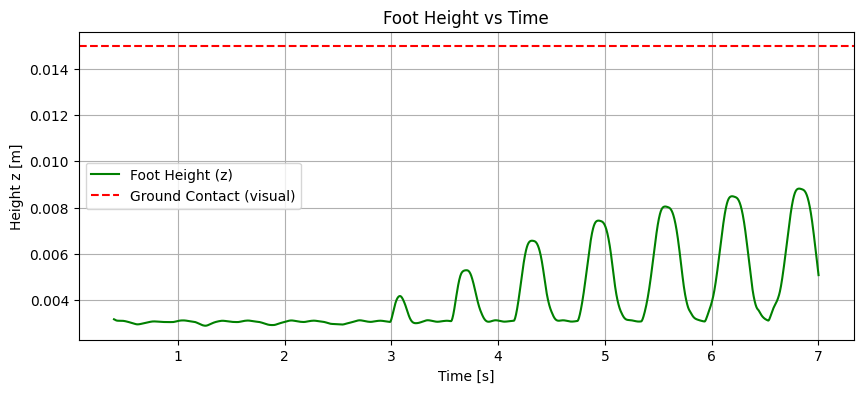

Cell 6: Plotted the vertical position of the foot over time and marked an approximate ground-contact height for gait analysis.


In [6]:
# @title 6. Plot Foot (End-Effector) Height vs Time

plt.figure(figsize=(10, 4))
plt.plot(times, z_positions, label="Foot Height (z)", color="green")
plt.axhline(y=0.015, color='r', linestyle='--', label="Ground Contact (visual)")
plt.xlabel("Time [s]")
plt.ylabel("Height z [m]")
plt.title("Foot Height vs Time")
plt.grid(True)
plt.legend()
plt.show()
print("Cell 6: Plotted the vertical position of the foot over time and marked an approximate ground-contact height for gait analysis.")

Cell 7: Plotted the estimated forward velocity of the foot/end-effector as a function of time to visualize locomotion speed.


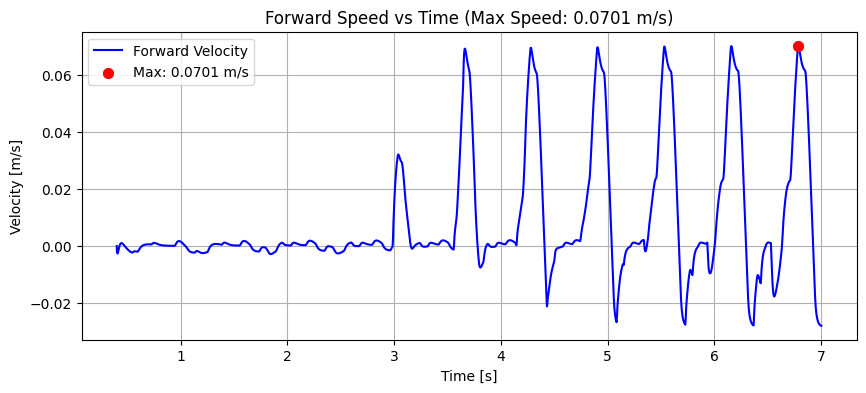

In [7]:
# @title 7. Plot Forward Velocity vs Time
print("Cell 7: Plotted the estimated forward velocity of the foot/end-effector as a function of time to visualize locomotion speed.")

# --- ADDED CODE START ---
# 1. Find maximum velocity
max_velocity = max(velocities)

# 2. Find the index where max velocity occurred to get the corresponding time
# Note: If using numpy arrays, use: max_index = np.argmax(velocities)
max_index = velocities.index(max_velocity)
time_of_max = times[max_index]
# --- ADDED CODE END ---


plt.figure(figsize=(10, 4))
plt.plot(times, velocities, label="Forward Velocity", color="blue")

# --- ADDED CODE START ---
# 3. Plot a red dot at the maximum point
# We plot a single point (scatter plot) at [time_of_max, max_velocity]
plt.scatter([time_of_max], [max_velocity], color="red", s=50, label=f"Max: {max_velocity:.4f} m/s", zorder=5)
# (s=50 controls dot size, zorder=5 ensures it sits on top of the blue line)
# --- ADDED CODE END ---

plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")

# --- MODIFIED LINE ---
# Update title to include the max value formatted to 2 decimal places
plt.title(f"Forward Speed vs Time (Max Speed: {max_velocity:.4f} m/s)")
# ---------------------

plt.grid(True)
plt.legend()
plt.show()


Cell 8: Plotted potential, kinetic, and total mechanical energy over time to inspect energy behavior and stability of the gait.
Simulation started...
Simulation complete. Peak Kinetic Energy: 0.0166 J


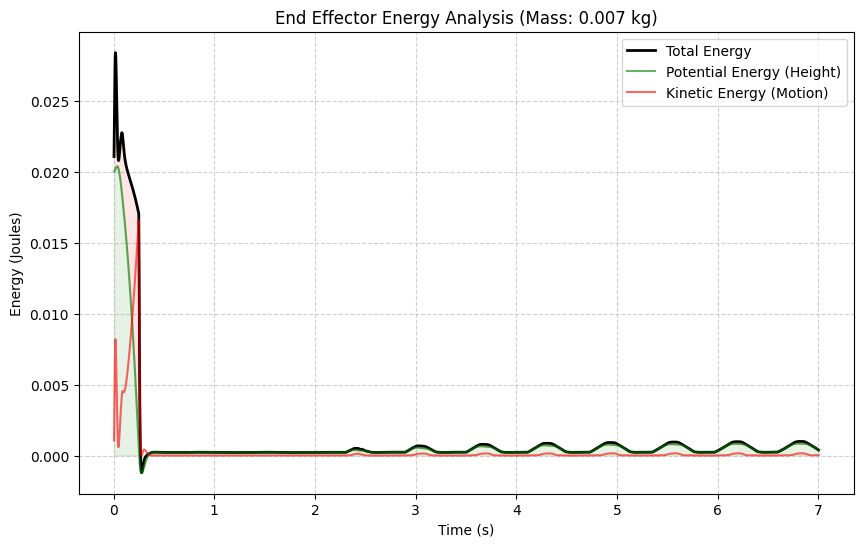

In [8]:
# @title 8. Calculate and Plot End-Effector Energy (Fixed)
print("Cell 8: Plotted potential, kinetic, and total mechanical energy over time to inspect energy behavior and stability of the gait.")
# --- 1. RESET SIMULATION ---
mujoco.mj_resetData(model, data) # <--- THIS FIXES THE ERROR
data.qpos[qA2_adr] = np.deg2rad(start_angle_A2) # Reset initial angles
data.qpos[qB1_adr] = np.deg2rad(start_angle_B1)

# --- SETUP ---
frames = []
green_tip_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, 'green_tip')
foot_body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, 'A32')
renderer = mujoco.Renderer(model, height=480, width=640)

# Get Mass of the foot link
foot_mass = model.body_mass[foot_body_id]
gravity = 9.81

# Data containers
times = []
ke_history = []  # Kinetic Energy
pe_history = []  # Potential Energy
total_e_history = [] # Total Energy

prev_pos = None

print("Simulation started...")

# --- SIMULATION LOOP ---
while data.time < duration:
    # 1. Targets
    target_A2_deg = mid_A2 + amp_A2 * np.cos(speed * data.time)
    target_B1_deg = mid_B1 + amp_B1 * np.cos(speed * data.time + phase_offset)

    # 2. Current State
    curr_qA2 = data.qpos[qA2_adr]
    curr_wA2 = data.qvel[dofA2_adr]
    curr_qB1 = data.qpos[qB1_adr]
    curr_wB1 = data.qvel[dofB1_adr]

    # 3. Control
    torque_A = calculate_real_torque(curr_qA2, curr_wA2, np.deg2rad(target_A2_deg))
    torque_B = calculate_real_torque(curr_qB1, curr_wB1, np.deg2rad(target_B1_deg))

    data.ctrl[0] = torque_A
    data.ctrl[1] = torque_B

    mujoco.mj_step(model, data)

    # 4. Energy Calculation
    current_pos = data.site_xpos[green_tip_id].copy()

    if prev_pos is not None:
        dt = 0.002
        velocity_vector = (current_pos - prev_pos) / dt
        velocity_mag = np.linalg.norm(velocity_vector)

        # Kinetic Energy: 1/2 * m * v^2
        ke = 0.5 * foot_mass * (velocity_mag ** 2)

        # Potential Energy: m * g * h
        pe = foot_mass * gravity * current_pos[2]

        ke_history.append(ke)
        pe_history.append(pe)
        total_e_history.append(ke + pe)
        times.append(data.time)

    prev_pos = current_pos

    # Render
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, camera="track_cam")
        frames.append(renderer.render())

# --- PLOTTING ---
if len(ke_history) > 0:
    print(f"Simulation complete. Peak Kinetic Energy: {max(ke_history):.4f} J")

    plt.figure(figsize=(10, 6))
    plt.plot(times, total_e_history, color='black', linewidth=2, label='Total Energy')
    plt.plot(times, pe_history, color='green', alpha=0.6, label='Potential Energy (Height)')
    plt.plot(times, ke_history, color='red', alpha=0.6, label='Kinetic Energy (Motion)')

    plt.fill_between(times, pe_history, color='green', alpha=0.1)
    plt.fill_between(times, pe_history, total_e_history, color='red', alpha=0.1)

    plt.title(f"End Effector Energy Analysis (Mass: {foot_mass:.3f} kg)")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (Joules)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()



In [9]:
# @title 2. Define Simulation Parameters and Motor Model
print("Cell 2: Defined all gait parameters and implemented a DC-motor-based torque model used to drive the joints.")
# --- GAIT / MOTION CONFIGURATION ---
start_angle_A2 = -80
end_angle_A2   = -160

start_angle_B1 = -70
end_angle_B1   = -130

duration    = 7.0      # total simulation time [s]
framerate   = 60       # video FPS
speed       = 10.0     # oscillation speed
phase_offset = 1.57    # phase offset between the two legs [rad] (4 different value: pi/2 for first 2 observations, pi/4, 3pi/4, pi)

# Sinusoid midpoints and amplitudes (deg)
mid_A2 = (start_angle_A2 + end_angle_A2) / 2
amp_A2 = (start_angle_A2 - end_angle_A2) / 2

mid_B1 = (start_angle_B1 + end_angle_B1) / 2
amp_B1 = (start_angle_B1 - end_angle_B1) / 2

# Threshold for detecting foot-ground contact (for gait analysis)
contact_threshold = 0.02  # [m]


# --- MOTOR / SERVO PHYSICS (simple DC motor model) ---
Vnom          = 6.0      # nominal motor voltage [V]
G             = 55.5     # gear ratio
i_stall       = 0.6      # stall current [A]
t_stall_motor = 0.15     # stall torque at motor shaft [Nm]
w_nl_deg      = 0.66 * 1000  # no-load speed [deg/s]

R    = Vnom / i_stall                 # winding resistance [Ohm]
w_nl = w_nl_deg * (np.pi / 180.0)     # no-load speed [rad/s]
kt   = t_stall_motor / i_stall        # torque constant [Nm/A]
ke   = kt                             # back-EMF constant (SI)
b_motor = (kt * i_stall) / (w_nl * G) # viscous friction (approx)
V_supply = 12.0                       # supply voltage [V]
kp_motor = 50.0                       # position gain for servo control


def calculate_real_torque(current_q, current_vel, desired_q):
    """DC motor model with simple position control -> joint torque."""
    error = desired_q - current_q
    V = kp_motor * error

    # Saturate voltage to supply
    if V > V_supply:
        V = V_supply
    if V < -V_supply:
        V = -V_supply

    # Motor-side angular velocity
    w_motor = current_vel * G

    # Motor current from electrical model
    current = (V - (ke * w_motor)) / R

    # Motor shaft torque with viscous losses
    torque_motor = (kt * current) - (b_motor * w_motor)

    # Return joint torque after gearbox
    return torque_motor * G


Cell 2: Defined all gait parameters and implemented a DC-motor-based torque model used to drive the joints.


In [10]:
# @title 3. Define MuJoCo XML Model
print("Cell 3: Defined the full MuJoCo MJCF model (rigid body, legs, foot, loop constraint, and camera) as an XML string.")
mjcf_xml = """
<mujoco model="5_bar_pendulum_scaled">
  <option timestep="0.002" gravity="0 0 -9.81" integrator="RK4" solver="Newton" iterations="100" tolerance="1e-4"/>

  <visual>
    <global offwidth="640" offheight="480"/>
    <rgba haze="1 1 1 1"/> <headlight active="1" diffuse="0.8 0.8 0.8"/>
  </visual>

  <asset>
     <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".8 .9 .9"/>
     <material name="grid_mat" texture="grid" texrepeat="1 1" texuniform="true" reflectance=".2"/>
  </asset>

  <default>
    <geom type="capsule" size="0.005" density="1000"/>
    <joint damping="5.0" armature="0.2"/>
  </default>

  <worldbody>
    <geom name="floor" type="plane" size="5 1 0.1" material="grid_mat" friction="2.0 0.005 0.0001"/>

    <body name="Rig" pos="0 0 0.5">
      <joint name="x_rail" type="slide" axis="1 0 0" damping="0.5"/>
      <joint name="z_bounce" type="slide" axis="0 0 1" damping="2.0" stiffness="0"/>

      <geom type="box" pos="0.15625 0 0" size="0.15625 0.01 0.01" rgba="0.2 0.2 0.2 1" mass="3"/>

      <geom name="stand_rear" type="capsule" fromto="0 0 0 0 0 -0.245" size="0.01" rgba="0.5 0.5 0.5 0.3" friction="0 0 0"/>
      <geom name="stand_front" type="capsule" fromto="0.15625 0 0 0.15625 0 -0.245" size="0.01" rgba="0.5 0.5 0.5 0.3" friction="0 0 0"/>

      <body name="A2" pos="0.25 0 0" euler="180 0 0">
        <joint name="qA2" axis="0 1 0"/>
        <geom fromto="0 0 0 0.078125 0 0" rgba="0.2 0.2 0.8 1"/>
        <body name="B2" pos="0.078125 0 0">
          <joint name="qB2" axis="0 1 0"/>
          <geom fromto="0 0 0 0.078125 0 0" rgba="0.2 0.8 0.8 1"/>
          <site name="s_B2_tip" pos="0.078125 0 0" size="0.005" rgba="0 0 0 0"/>
          <geom fromto="0.078125 0 0 0.161375 0 0" rgba="0 0.8 0 1"/>
          <body name="A32" pos="0.161375 0 0">
              <joint name="qA32" axis="0 1 0" stiffness="500" damping="10"/>
              <geom fromto="0 0 0 0.041625 0 0" rgba="0 1 0 1"/>
              <geom name="foot" type="sphere" pos="0.041625 0 0" size="0.01" friction="100"/>
              <site name="green_tip" pos="0.041625 0 0" size="0.008" rgba="1 0 0 1"/>
          </body>
        </body>
      </body>

      <body name="B1" pos="0.3125 0 0" euler="180 0 0">
        <joint name="qB1" axis="0 1 0"/>
        <geom fromto="0 0 0 0.078125 0 0" rgba="0.8 0.2 0.2 1"/>
        <body name="C1" pos="0.078125 0 0">
          <joint name="qC1" axis="0 1 0"/>
          <geom fromto="0 0 0 0.078125 0 0" rgba="0.8 0.2 0.8 1"/>
          <site name="s_C1_tip" pos="0.078125 0 0" size="0.005" rgba="0 0 0 0"/>
        </body>
      </body>
    </body>

    <camera name="track_cam" mode="track" target="Rig" pos="0.3 -1.5 0.5" xyaxes="1 0 0 0 0 1"/>
  </worldbody>

  <equality>
    <connect name="loop_closure" site1="s_B2_tip" site2="s_C1_tip"/>
  </equality>

  <actuator>
    <motor name="servo_A2" joint="qA2" gear="1"/>
    <motor name="servo_B1" joint="qB1" gear="1"/>
  </actuator>

</mujoco>"""


Cell 3: Defined the full MuJoCo MJCF model (rigid body, legs, foot, loop constraint, and camera) as an XML string.


In [11]:
# @title 4. Run Simulation and Generate Video Frames
print("Cell 4: Built the model, ran warmup + main simulation, logged kinematics and energy, rendered frames, computed gait stats, and saved frames to a video file.")
# Build model and data
model = mujoco.MjModel.from_xml_string(mjcf_xml)
data = mujoco.MjData(model)
mujoco.mj_resetData(model, data)

# Simulation timestep from model
dt = model.opt.timestep

# Joint indices / addresses
qA2_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'qA2')
qB1_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'qB1')

qA2_adr   = model.jnt_qposadr[qA2_id]
qB1_adr   = model.jnt_qposadr[qB1_id]
dofA2_adr = model.jnt_dofadr[qA2_id]
dofB1_adr = model.jnt_dofadr[qB1_id]

# Initial joint configuration
data.qpos[qA2_adr] = np.deg2rad(start_angle_A2)
data.qpos[qB1_adr] = np.deg2rad(start_angle_B1)

# --- WARMUP / SETTLING PHASE ---
print("Settling physics (Warmup)...")
for _ in range(200):
    curr_qA2 = data.qpos[qA2_adr]
    curr_wA2 = data.qvel[dofA2_adr]
    trq_A = calculate_real_torque(curr_qA2, curr_wA2, np.deg2rad(start_angle_A2))

    curr_qB1 = data.qpos[qB1_adr]
    curr_wB1 = data.qvel[dofB1_adr]
    trq_B = calculate_real_torque(curr_qB1, curr_wB1, np.deg2rad(start_angle_B1))

    data.ctrl[0] = trq_A
    data.ctrl[1] = trq_B
    mujoco.mj_step(model, data)

data.qvel[:] = 0.0
print("Physics settled. Starting simulation...")

# --- PREPARE LOGGING & RENDERING ---
green_tip_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, 'green_tip')
renderer = mujoco.Renderer(model, height=480, width=640)

times        = []
x_positions  = []
z_positions  = []
velocities   = []

energy_potential = []   # potential energy
energy_kinetic   = []   # kinetic energy
energy_total     = []   # total mechanical energy

frames = []

# --- MAIN SIMULATION LOOP ---
while data.time < duration:
    # Oscillatory target angles (deg)
    target_A2_deg = mid_A2 + amp_A2 * np.cos(speed * data.time)
    target_B1_deg = mid_B1 + amp_B1 * np.cos(speed * data.time + phase_offset)

    # Convert to radians
    target_A2 = np.deg2rad(target_A2_deg)
    target_B1 = np.deg2rad(target_B1_deg)

    # Current state
    curr_qA2 = data.qpos[qA2_adr]
    curr_wA2 = data.qvel[dofA2_adr]
    curr_qB1 = data.qpos[qB1_adr]
    curr_wB1 = data.qvel[dofB1_adr]

    # Motor torques
    torque_A = calculate_real_torque(curr_qA2, curr_wA2, target_A2)
    torque_B = calculate_real_torque(curr_qB1, curr_wB1, target_B1)

    data.ctrl[0] = torque_A
    data.ctrl[1] = torque_B

    # Advance physics
    mujoco.mj_step(model, data)

    # --- KINEMATICS LOGGING (end-effector) ---
    pos = data.site_xpos[green_tip_id]  # [x, y, z] of green_tip
    if len(x_positions) > 0:
        vel = (pos[0] - x_positions[-1]) / dt
    else:
        vel = 0.0

    times.append(data.time)
    x_positions.append(pos[0])
    z_positions.append(pos[2])
    velocities.append(vel)

    # --- ENERGY LOGGING ---
    # Compute potential and kinetic energy into data.energy[0], data.energy[1]
    mujoco.mj_energyPos(model, data)
    mujoco.mj_energyVel(model, data)
    energy_potential.append(float(data.energy[0]))            # potential
    energy_kinetic.append(float(data.energy[1]))              # kinetic
    energy_total.append(float(data.energy[0] + data.energy[1]))  # total

    # --- RENDER VIDEO FRAMES ---
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, camera="track_cam")
        frames.append(renderer.render())

print(f"Simulation complete. Generated {len(frames)} frames and {len(times)} time samples.")

# --- GAIT STATS (STRIDE LENGTH) ---
contacts = []
for i in range(1, len(z_positions)):
    if z_positions[i-1] > contact_threshold and z_positions[i] <= contact_threshold:
        contacts.append(i)

print("\n--- GAIT ANALYSIS (SCALED 1.25x) ---")
if len(contacts) > 1:
    total_dist = 0.0
    for i in range(len(contacts) - 1):
        idx_now  = contacts[i]
        idx_next = contacts[i+1]
        stride_len = x_positions[idx_next] - x_positions[idx_now]
        print(f"Stride {i+1}: Length = {stride_len:.3f} m")
        total_dist += stride_len
    print(f"Average Stride Length: {total_dist / (len(contacts) - 1):.3f} m")
else:
    print("Not enough contacts detected to compute stride length.")

# --- SAVE VIDEO FILE ---
video_name = "wide_stride_simulation2.mp4"
media.write_video(video_name, frames, fps=framerate)
print(f"Video written to {video_name}")


Cell 4: Built the model, ran warmup + main simulation, logged kinematics and energy, rendered frames, computed gait stats, and saved frames to a video file.
Settling physics (Warmup)...
Physics settled. Starting simulation...
Simulation complete. Generated 421 frames and 3301 time samples.

--- GAIT ANALYSIS (SCALED 1.25x) ---
Not enough contacts detected to compute stride length.
Video written to wide_stride_simulation2.mp4


In [12]:
# @title 5. Display Video
# Inline playback in notebook
print("Cell 5: Displayed the simulation video inline in the notebook.")
media.show_video(frames, fps=framerate)


Cell 5: Displayed the simulation video inline in the notebook.


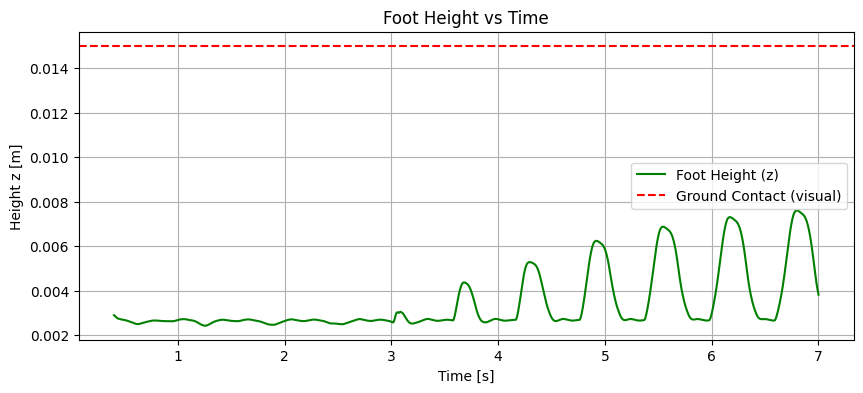

Cell 6: Plotted the vertical position of the foot over time and marked an approximate ground-contact height for gait analysis.


In [13]:
# @title 6. Plot Foot (End-Effector) Height vs Time

plt.figure(figsize=(10, 4))
plt.plot(times, z_positions, label="Foot Height (z)", color="green")
plt.axhline(y=0.015, color='r', linestyle='--', label="Ground Contact (visual)")
plt.xlabel("Time [s]")
plt.ylabel("Height z [m]")
plt.title("Foot Height vs Time")
plt.grid(True)
plt.legend()
plt.show()
print("Cell 6: Plotted the vertical position of the foot over time and marked an approximate ground-contact height for gait analysis.")

Cell 7: Plotted the estimated forward velocity of the foot/end-effector as a function of time to visualize locomotion speed.


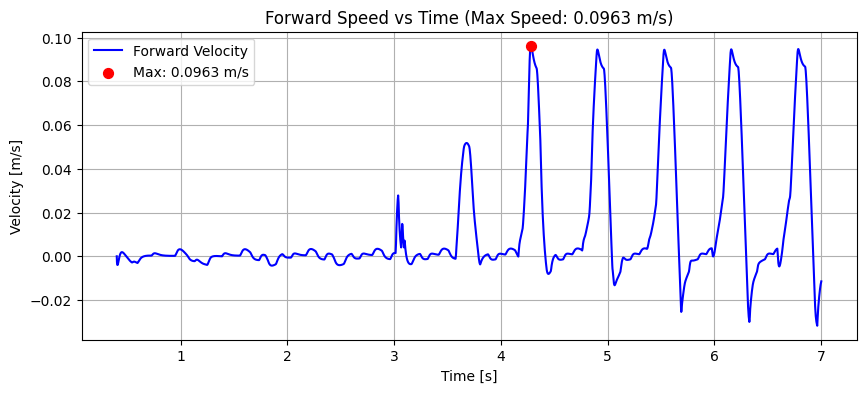

In [14]:
# @title 7. Plot Forward Velocity vs Time
print("Cell 7: Plotted the estimated forward velocity of the foot/end-effector as a function of time to visualize locomotion speed.")

# --- ADDED CODE START ---
# 1. Find maximum velocity
max_velocity = max(velocities)

# 2. Find the index where max velocity occurred to get the corresponding time
# Note: If using numpy arrays, use: max_index = np.argmax(velocities)
max_index = velocities.index(max_velocity)
time_of_max = times[max_index]
# --- ADDED CODE END ---


plt.figure(figsize=(10, 4))
plt.plot(times, velocities, label="Forward Velocity", color="blue")

# --- ADDED CODE START ---
# 3. Plot a red dot at the maximum point
# We plot a single point (scatter plot) at [time_of_max, max_velocity]
plt.scatter([time_of_max], [max_velocity], color="red", s=50, label=f"Max: {max_velocity:.4f} m/s", zorder=5)
# (s=50 controls dot size, zorder=5 ensures it sits on top of the blue line)
# --- ADDED CODE END ---

plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")

# --- MODIFIED LINE ---
# Update title to include the max value formatted to 2 decimal places
plt.title(f"Forward Speed vs Time (Max Speed: {max_velocity:.4f} m/s)")
# ---------------------

plt.grid(True)
plt.legend()
plt.show()

Cell 8: Plotted potential, kinetic, and total mechanical energy over time to inspect energy behavior and stability of the gait.
Simulation started...
Simulation complete. Peak Kinetic Energy: 0.0147 J


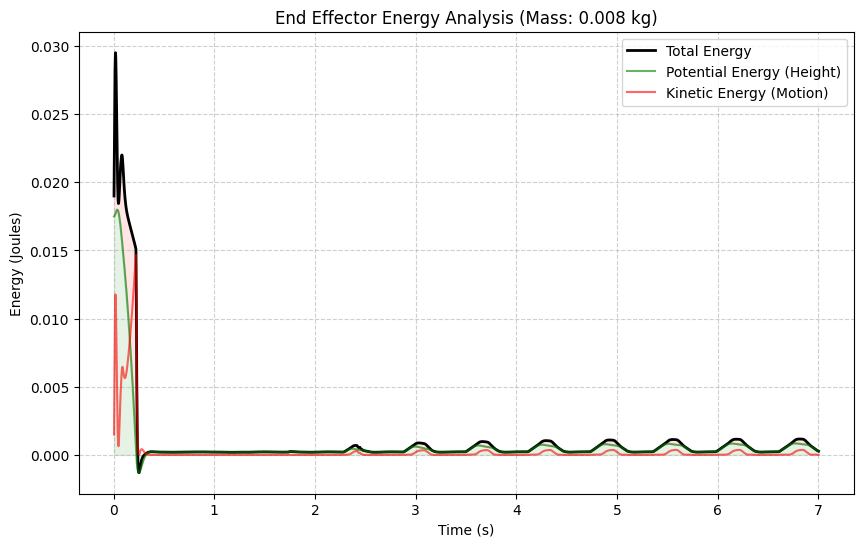

In [15]:
# @title 8. Calculate and Plot End-Effector Energy (Fixed)
print("Cell 8: Plotted potential, kinetic, and total mechanical energy over time to inspect energy behavior and stability of the gait.")
# --- 1. RESET SIMULATION ---
mujoco.mj_resetData(model, data) # <--- THIS FIXES THE ERROR
data.qpos[qA2_adr] = np.deg2rad(start_angle_A2) # Reset initial angles
data.qpos[qB1_adr] = np.deg2rad(start_angle_B1)

# --- SETUP ---
frames = []
green_tip_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, 'green_tip')
foot_body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, 'A32')
renderer = mujoco.Renderer(model, height=480, width=640)

# Get Mass of the foot link
foot_mass = model.body_mass[foot_body_id]
gravity = 9.81

# Data containers
times = []
ke_history = []  # Kinetic Energy
pe_history = []  # Potential Energy
total_e_history = [] # Total Energy

prev_pos = None

print("Simulation started...")

# --- SIMULATION LOOP ---
while data.time < duration:
    # 1. Targets
    target_A2_deg = mid_A2 + amp_A2 * np.cos(speed * data.time)
    target_B1_deg = mid_B1 + amp_B1 * np.cos(speed * data.time + phase_offset)

    # 2. Current State
    curr_qA2 = data.qpos[qA2_adr]
    curr_wA2 = data.qvel[dofA2_adr]
    curr_qB1 = data.qpos[qB1_adr]
    curr_wB1 = data.qvel[dofB1_adr]

    # 3. Control
    torque_A = calculate_real_torque(curr_qA2, curr_wA2, np.deg2rad(target_A2_deg))
    torque_B = calculate_real_torque(curr_qB1, curr_wB1, np.deg2rad(target_B1_deg))

    data.ctrl[0] = torque_A
    data.ctrl[1] = torque_B

    mujoco.mj_step(model, data)

    # 4. Energy Calculation
    current_pos = data.site_xpos[green_tip_id].copy()

    if prev_pos is not None:
        dt = 0.002
        velocity_vector = (current_pos - prev_pos) / dt
        velocity_mag = np.linalg.norm(velocity_vector)

        # Kinetic Energy: 1/2 * m * v^2
        ke = 0.5 * foot_mass * (velocity_mag ** 2)

        # Potential Energy: m * g * h
        pe = foot_mass * gravity * current_pos[2]

        ke_history.append(ke)
        pe_history.append(pe)
        total_e_history.append(ke + pe)
        times.append(data.time)

    prev_pos = current_pos

    # Render
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, camera="track_cam")
        frames.append(renderer.render())

# --- PLOTTING ---
if len(ke_history) > 0:
    print(f"Simulation complete. Peak Kinetic Energy: {max(ke_history):.4f} J")

    plt.figure(figsize=(10, 6))
    plt.plot(times, total_e_history, color='black', linewidth=2, label='Total Energy')
    plt.plot(times, pe_history, color='green', alpha=0.6, label='Potential Energy (Height)')
    plt.plot(times, ke_history, color='red', alpha=0.6, label='Kinetic Energy (Motion)')

    plt.fill_between(times, pe_history, color='green', alpha=0.1)
    plt.fill_between(times, pe_history, total_e_history, color='red', alpha=0.1)

    plt.title(f"End Effector Energy Analysis (Mass: {foot_mass:.3f} kg)")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (Joules)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

else:
    print("Error: No data recorded. Check if simulation duration > 0.")

In [16]:
# @title 2. Define Simulation Parameters and Motor Model
print("Cell 2: Defined all gait parameters and implemented a DC-motor-based torque model used to drive the joints.")
# --- GAIT / MOTION CONFIGURATION ---
start_angle_A2 = -80
end_angle_A2   = -160

start_angle_B1 = -70
end_angle_B1   = -130

duration    = 7.0      # total simulation time [s]
framerate   = 60       # video FPS
speed       = 10.0     # oscillation speed
phase_offset = 0.785    # phase offset between the two legs [rad] (4 different value: pi/2 for first 2 observations, pi/4, 3pi/4, pi)

# Sinusoid midpoints and amplitudes (deg)
mid_A2 = (start_angle_A2 + end_angle_A2) / 2
amp_A2 = (start_angle_A2 - end_angle_A2) / 2

mid_B1 = (start_angle_B1 + end_angle_B1) / 2
amp_B1 = (start_angle_B1 - end_angle_B1) / 2

# Threshold for detecting foot-ground contact (for gait analysis)
contact_threshold = 0.02  # [m]


# --- MOTOR / SERVO PHYSICS (simple DC motor model) ---
Vnom          = 6.0      # nominal motor voltage [V]
G             = 55.5     # gear ratio
i_stall       = 0.6      # stall current [A]
t_stall_motor = 0.15     # stall torque at motor shaft [Nm]
w_nl_deg      = 0.66 * 1000  # no-load speed [deg/s]

R    = Vnom / i_stall                 # winding resistance [Ohm]
w_nl = w_nl_deg * (np.pi / 180.0)     # no-load speed [rad/s]
kt   = t_stall_motor / i_stall        # torque constant [Nm/A]
ke   = kt                             # back-EMF constant (SI)
b_motor = (kt * i_stall) / (w_nl * G) # viscous friction (approx)
V_supply = 12.0                       # supply voltage [V]
kp_motor = 50.0                       # position gain for servo control


def calculate_real_torque(current_q, current_vel, desired_q):
    """DC motor model with simple position control -> joint torque."""
    error = desired_q - current_q
    V = kp_motor * error

    # Saturate voltage to supply
    if V > V_supply:
        V = V_supply
    if V < -V_supply:
        V = -V_supply

    # Motor-side angular velocity
    w_motor = current_vel * G

    # Motor current from electrical model
    current = (V - (ke * w_motor)) / R

    # Motor shaft torque with viscous losses
    torque_motor = (kt * current) - (b_motor * w_motor)

    # Return joint torque after gearbox
    return torque_motor * G


Cell 2: Defined all gait parameters and implemented a DC-motor-based torque model used to drive the joints.


In [17]:
# @title 3. xml model
print("Cell 3: Defined the full MuJoCo MJCF model (rigid body, legs, foot, loop constraint, and camera) as an XML string.")
mjcf_xml = """
<mujoco model="5_bar_pendulum_scaled">
  <option timestep="0.002" gravity="0 0 -9.81" integrator="RK4" solver="Newton" iterations="100" tolerance="1e-4"/>

  <visual>
    <global offwidth="640" offheight="480"/>
    <rgba haze="1 1 1 1"/> <headlight active="1" diffuse="0.8 0.8 0.8"/>
  </visual>

  <asset>
     <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".8 .9 .9"/>
     <material name="grid_mat" texture="grid" texrepeat="1 1" texuniform="true" reflectance=".2"/>
  </asset>

  <default>
    <geom type="capsule" size="0.005" density="1000"/>
    <joint damping="5.0" armature="0.2"/>
  </default>

  <worldbody>
    <geom name="floor" type="plane" size="5 1 0.1" material="grid_mat" friction="2.0 0.005 0.0001"/>

    <body name="Rig" pos="0 0 0.5">
      <joint name="x_rail" type="slide" axis="1 0 0" damping="0.5"/>
      <joint name="z_bounce" type="slide" axis="0 0 1" damping="2.0" stiffness="0"/>

      <geom type="box" pos="0.15625 0 0" size="0.15625 0.01 0.01" rgba="0.2 0.2 0.2 1" mass="3"/>

      <geom name="stand_rear" type="capsule" fromto="0 0 0 0 0 -0.1875" size="0.01" rgba="0.5 0.5 0.5 0.3" friction="0 0 0"/>
      <geom name="stand_front" type="capsule" fromto="0.15625 0 0 0.15625 0 -0.1875" size="0.01" rgba="0.5 0.5 0.5 0.3" friction="0 0 0"/>

      <body name="A2" pos="0.25 0 0" euler="180 0 0">
        <joint name="qA2" axis="0 1 0"/>
        <geom fromto="0 0 0 0.0625 0 0" rgba="0.2 0.2 0.8 1"/>
        <body name="B2" pos="0.0625 0 0">
          <joint name="qB2" axis="0 1 0"/>
          <geom fromto="0 0 0 0.0625 0 0" rgba="0.2 0.8 0.8 1"/>
          <site name="s_B2_tip" pos="0.0625 0 0" size="0.005" rgba="0 0 0 0"/>
          <geom fromto="0.0625 0 0 0.1291 0 0" rgba="0 0.8 0 1"/>
          <body name="A32" pos="0.1291 0 0">
              <joint name="qA32" axis="0 1 0" stiffness="500" damping="10"/>
              <geom fromto="0 0 0 0.0333 0 0" rgba="0 1 0 1"/>
              <geom name="foot" type="sphere" pos="0.0333 0 0" size="0.01" friction="100"/>
              <site name="green_tip" pos="0.0333 0 0" size="0.008" rgba="1 0 0 1"/>
          </body>
        </body>
      </body>

      <body name="B1" pos="0.3125 0 0" euler="180 0 0">
        <joint name="qB1" axis="0 1 0"/>
        <geom fromto="0 0 0 0.0625 0 0" rgba="0.8 0.2 0.2 1"/>
        <body name="C1" pos="0.0625 0 0">
          <joint name="qC1" axis="0 1 0"/>
          <geom fromto="0 0 0 0.0625 0 0" rgba="0.8 0.2 0.8 1"/>
          <site name="s_C1_tip" pos="0.0625 0 0" size="0.005" rgba="0 0 0 0"/>
        </body>
      </body>
    </body>

    <camera name="track_cam" mode="track" target="Rig" pos="0.3 -1.5 0.5" xyaxes="1 0 0 0 0 1"/>
  </worldbody>

  <equality>
    <connect name="loop_closure" site1="s_B2_tip" site2="s_C1_tip"/>
  </equality>

  <actuator>
    <motor name="servo_A2" joint="qA2" gear="1"/>
    <motor name="servo_B1" joint="qB1" gear="1"/>
  </actuator>

</mujoco>"""

Cell 3: Defined the full MuJoCo MJCF model (rigid body, legs, foot, loop constraint, and camera) as an XML string.


In [18]:
# @title 4. Run Simulation and Generate Video Frames
print("Cell 4: Built the model, ran warmup + main simulation, logged kinematics and energy, rendered frames, computed gait stats, and saved frames to a video file.")
# Build model and data
model = mujoco.MjModel.from_xml_string(mjcf_xml)
data = mujoco.MjData(model)
mujoco.mj_resetData(model, data)

# Simulation timestep from model
dt = model.opt.timestep

# Joint indices / addresses
qA2_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'qA2')
qB1_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'qB1')

qA2_adr   = model.jnt_qposadr[qA2_id]
qB1_adr   = model.jnt_qposadr[qB1_id]
dofA2_adr = model.jnt_dofadr[qA2_id]
dofB1_adr = model.jnt_dofadr[qB1_id]

# Initial joint configuration
data.qpos[qA2_adr] = np.deg2rad(start_angle_A2)
data.qpos[qB1_adr] = np.deg2rad(start_angle_B1)

# --- WARMUP / SETTLING PHASE ---
print("Settling physics (Warmup)...")
for _ in range(200):
    curr_qA2 = data.qpos[qA2_adr]
    curr_wA2 = data.qvel[dofA2_adr]
    trq_A = calculate_real_torque(curr_qA2, curr_wA2, np.deg2rad(start_angle_A2))

    curr_qB1 = data.qpos[qB1_adr]
    curr_wB1 = data.qvel[dofB1_adr]
    trq_B = calculate_real_torque(curr_qB1, curr_wB1, np.deg2rad(start_angle_B1))

    data.ctrl[0] = trq_A
    data.ctrl[1] = trq_B
    mujoco.mj_step(model, data)

data.qvel[:] = 0.0
print("Physics settled. Starting simulation...")

# --- PREPARE LOGGING & RENDERING ---
green_tip_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, 'green_tip')
renderer = mujoco.Renderer(model, height=480, width=640)

times        = []
x_positions  = []
z_positions  = []
velocities   = []

energy_potential = []   # potential energy
energy_kinetic   = []   # kinetic energy
energy_total     = []   # total mechanical energy

frames = []

# --- MAIN SIMULATION LOOP ---
while data.time < duration:
    # Oscillatory target angles (deg)
    target_A2_deg = mid_A2 + amp_A2 * np.cos(speed * data.time)
    target_B1_deg = mid_B1 + amp_B1 * np.cos(speed * data.time + phase_offset)

    # Convert to radians
    target_A2 = np.deg2rad(target_A2_deg)
    target_B1 = np.deg2rad(target_B1_deg)

    # Current state
    curr_qA2 = data.qpos[qA2_adr]
    curr_wA2 = data.qvel[dofA2_adr]
    curr_qB1 = data.qpos[qB1_adr]
    curr_wB1 = data.qvel[dofB1_adr]

    # Motor torques
    torque_A = calculate_real_torque(curr_qA2, curr_wA2, target_A2)
    torque_B = calculate_real_torque(curr_qB1, curr_wB1, target_B1)

    data.ctrl[0] = torque_A
    data.ctrl[1] = torque_B

    # Advance physics
    mujoco.mj_step(model, data)

    # --- KINEMATICS LOGGING (end-effector) ---
    pos = data.site_xpos[green_tip_id]  # [x, y, z] of green_tip
    if len(x_positions) > 0:
        vel = (pos[0] - x_positions[-1]) / dt
    else:
        vel = 0.0

    times.append(data.time)
    x_positions.append(pos[0])
    z_positions.append(pos[2])
    velocities.append(vel)

    # --- ENERGY LOGGING ---
    # Compute potential and kinetic energy into data.energy[0], data.energy[1]
    mujoco.mj_energyPos(model, data)
    mujoco.mj_energyVel(model, data)
    energy_potential.append(float(data.energy[0]))            # potential
    energy_kinetic.append(float(data.energy[1]))              # kinetic
    energy_total.append(float(data.energy[0] + data.energy[1]))  # total

    # --- RENDER VIDEO FRAMES ---
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, camera="track_cam")
        frames.append(renderer.render())

print(f"Simulation complete. Generated {len(frames)} frames and {len(times)} time samples.")

# --- GAIT STATS (STRIDE LENGTH) ---
contacts = []
for i in range(1, len(z_positions)):
    if z_positions[i-1] > contact_threshold and z_positions[i] <= contact_threshold:
        contacts.append(i)

print("\n--- GAIT ANALYSIS ---")
if len(contacts) > 1:
    total_dist = 0.0
    for i in range(len(contacts) - 1):
        idx_now  = contacts[i]
        idx_next = contacts[i+1]
        stride_len = x_positions[idx_next] - x_positions[idx_now]
        print(f"Stride {i+1}: Length = {stride_len:.3f} m")
        total_dist += stride_len
    print(f"Average Stride Length: {total_dist / (len(contacts) - 1):.3f} m")
else:
    print("Not enough contacts detected to compute stride length.")




Cell 4: Built the model, ran warmup + main simulation, logged kinematics and energy, rendered frames, computed gait stats, and saved frames to a video file.
Settling physics (Warmup)...
Physics settled. Starting simulation...
Simulation complete. Generated 421 frames and 3301 time samples.

--- GAIT ANALYSIS ---
Not enough contacts detected to compute stride length.


In [19]:
# @title 5. Display Video
# Inline playback in notebook
print("Cell 5: Displayed the simulation video inline in the notebook.")
media.show_video(frames, fps=framerate)


Cell 5: Displayed the simulation video inline in the notebook.


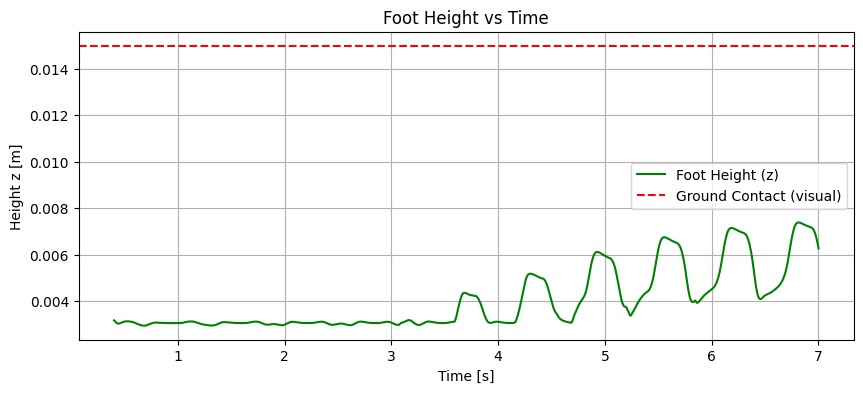

Cell 6: Plotted the vertical position of the foot over time and marked an approximate ground-contact height for gait analysis.


In [20]:
# @title 6. Plot Foot (End-Effector) Height vs Time

plt.figure(figsize=(10, 4))
plt.plot(times, z_positions, label="Foot Height (z)", color="green")
plt.axhline(y=0.015, color='r', linestyle='--', label="Ground Contact (visual)")
plt.xlabel("Time [s]")
plt.ylabel("Height z [m]")
plt.title("Foot Height vs Time")
plt.grid(True)
plt.legend()
plt.show()
print("Cell 6: Plotted the vertical position of the foot over time and marked an approximate ground-contact height for gait analysis.")

Cell 7: Plotted the estimated forward velocity of the foot/end-effector as a function of time to visualize locomotion speed.


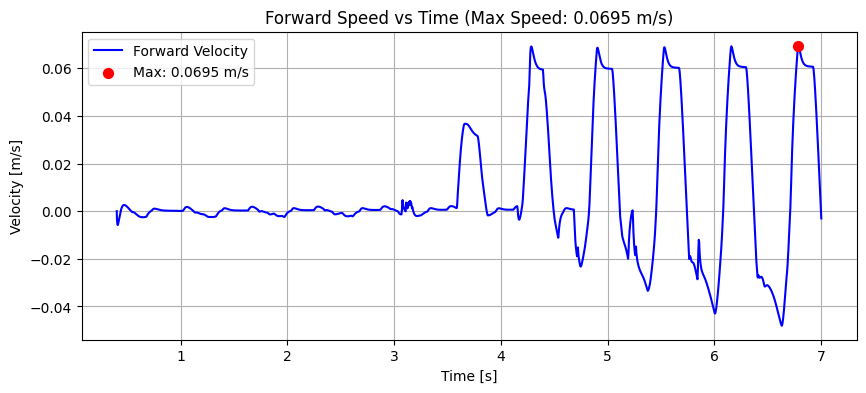

In [21]:
# @title 7. Plot Forward Velocity vs Time
print("Cell 7: Plotted the estimated forward velocity of the foot/end-effector as a function of time to visualize locomotion speed.")

# --- ADDED CODE START ---
# 1. Find maximum velocity
max_velocity = max(velocities)

# 2. Find the index where max velocity occurred to get the corresponding time
# Note: If using numpy arrays, use: max_index = np.argmax(velocities)
max_index = velocities.index(max_velocity)
time_of_max = times[max_index]
# --- ADDED CODE END ---


plt.figure(figsize=(10, 4))
plt.plot(times, velocities, label="Forward Velocity", color="blue")

# --- ADDED CODE START ---
# 3. Plot a red dot at the maximum point
# We plot a single point (scatter plot) at [time_of_max, max_velocity]
plt.scatter([time_of_max], [max_velocity], color="red", s=50, label=f"Max: {max_velocity:.4f} m/s", zorder=5)
# (s=50 controls dot size, zorder=5 ensures it sits on top of the blue line)
# --- ADDED CODE END ---

plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")

# --- MODIFIED LINE ---
# Update title to include the max value formatted to 2 decimal places
plt.title(f"Forward Speed vs Time (Max Speed: {max_velocity:.4f} m/s)")
# ---------------------

plt.grid(True)
plt.legend()
plt.show()

Cell 8: Plotted potential, kinetic, and total mechanical energy over time to inspect energy behavior and stability of the gait.
Simulation started...
Simulation complete. Peak Kinetic Energy: 0.0167 J


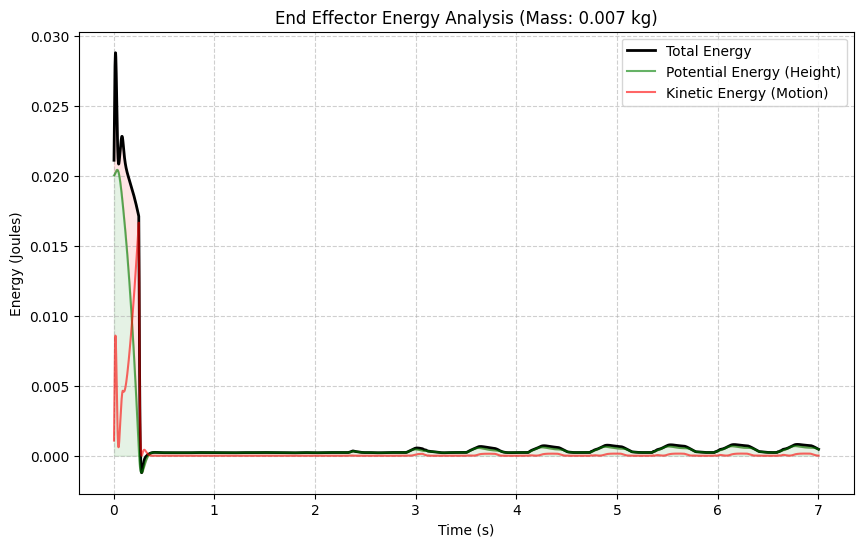

In [22]:
# @title 8. Calculate and Plot End-Effector Energy (Fixed)
print("Cell 8: Plotted potential, kinetic, and total mechanical energy over time to inspect energy behavior and stability of the gait.")
# --- 1. RESET SIMULATION ---
mujoco.mj_resetData(model, data) # <--- THIS FIXES THE ERROR
data.qpos[qA2_adr] = np.deg2rad(start_angle_A2) # Reset initial angles
data.qpos[qB1_adr] = np.deg2rad(start_angle_B1)

# --- SETUP ---
frames = []
green_tip_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, 'green_tip')
foot_body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, 'A32')
renderer = mujoco.Renderer(model, height=480, width=640)

# Get Mass of the foot link
foot_mass = model.body_mass[foot_body_id]
gravity = 9.81

# Data containers
times = []
ke_history = []  # Kinetic Energy
pe_history = []  # Potential Energy
total_e_history = [] # Total Energy

prev_pos = None

print("Simulation started...")

# --- SIMULATION LOOP ---
while data.time < duration:
    # 1. Targets
    target_A2_deg = mid_A2 + amp_A2 * np.cos(speed * data.time)
    target_B1_deg = mid_B1 + amp_B1 * np.cos(speed * data.time + phase_offset)

    # 2. Current State
    curr_qA2 = data.qpos[qA2_adr]
    curr_wA2 = data.qvel[dofA2_adr]
    curr_qB1 = data.qpos[qB1_adr]
    curr_wB1 = data.qvel[dofB1_adr]

    # 3. Control
    torque_A = calculate_real_torque(curr_qA2, curr_wA2, np.deg2rad(target_A2_deg))
    torque_B = calculate_real_torque(curr_qB1, curr_wB1, np.deg2rad(target_B1_deg))

    data.ctrl[0] = torque_A
    data.ctrl[1] = torque_B

    mujoco.mj_step(model, data)

    # 4. Energy Calculation
    current_pos = data.site_xpos[green_tip_id].copy()

    if prev_pos is not None:
        dt = 0.002
        velocity_vector = (current_pos - prev_pos) / dt
        velocity_mag = np.linalg.norm(velocity_vector)

        # Kinetic Energy: 1/2 * m * v^2
        ke = 0.5 * foot_mass * (velocity_mag ** 2)

        # Potential Energy: m * g * h
        pe = foot_mass * gravity * current_pos[2]

        ke_history.append(ke)
        pe_history.append(pe)
        total_e_history.append(ke + pe)
        times.append(data.time)

    prev_pos = current_pos

    # Render
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, camera="track_cam")
        frames.append(renderer.render())

# --- PLOTTING ---
if len(ke_history) > 0:
    print(f"Simulation complete. Peak Kinetic Energy: {max(ke_history):.4f} J")

    plt.figure(figsize=(10, 6))
    plt.plot(times, total_e_history, color='black', linewidth=2, label='Total Energy')
    plt.plot(times, pe_history, color='green', alpha=0.6, label='Potential Energy (Height)')
    plt.plot(times, ke_history, color='red', alpha=0.6, label='Kinetic Energy (Motion)')

    plt.fill_between(times, pe_history, color='green', alpha=0.1)
    plt.fill_between(times, pe_history, total_e_history, color='red', alpha=0.1)

    plt.title(f"End Effector Energy Analysis (Mass: {foot_mass:.3f} kg)")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (Joules)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

else:
    print("Error: No data recorded. Check if simulation duration > 0.")

In [23]:
# @title 2. Define Simulation Parameters and Motor Model
print("Cell 2: Defined all gait parameters and implemented a DC-motor-based torque model used to drive the joints.")
# --- GAIT / MOTION CONFIGURATION ---
start_angle_A2 = -80
end_angle_A2   = -160

start_angle_B1 = -70
end_angle_B1   = -130

duration    = 7.0      # total simulation time [s]
framerate   = 60       # video FPS
speed       = 10.0     # oscillation speed
phase_offset = 2.355    # phase offset between the two legs [rad] (4 different value: pi/2 for first 2 observations, pi/4, 3pi/4, pi)

# Sinusoid midpoints and amplitudes (deg)
mid_A2 = (start_angle_A2 + end_angle_A2) / 2
amp_A2 = (start_angle_A2 - end_angle_A2) / 2

mid_B1 = (start_angle_B1 + end_angle_B1) / 2
amp_B1 = (start_angle_B1 - end_angle_B1) / 2

# Threshold for detecting foot-ground contact (for gait analysis)
contact_threshold = 0.02  # [m]


# --- MOTOR / SERVO PHYSICS (simple DC motor model) ---
Vnom          = 6.0      # nominal motor voltage [V]
G             = 55.5     # gear ratio
i_stall       = 0.6      # stall current [A]
t_stall_motor = 0.15     # stall torque at motor shaft [Nm]
w_nl_deg      = 0.66 * 1000  # no-load speed [deg/s]

R    = Vnom / i_stall                 # winding resistance [Ohm]
w_nl = w_nl_deg * (np.pi / 180.0)     # no-load speed [rad/s]
kt   = t_stall_motor / i_stall        # torque constant [Nm/A]
ke   = kt                             # back-EMF constant (SI)
b_motor = (kt * i_stall) / (w_nl * G) # viscous friction (approx)
V_supply = 12.0                       # supply voltage [V]
kp_motor = 50.0                       # position gain for servo control


def calculate_real_torque(current_q, current_vel, desired_q):
    """DC motor model with simple position control -> joint torque."""
    error = desired_q - current_q
    V = kp_motor * error

    # Saturate voltage to supply
    if V > V_supply:
        V = V_supply
    if V < -V_supply:
        V = -V_supply

    # Motor-side angular velocity
    w_motor = current_vel * G

    # Motor current from electrical model
    current = (V - (ke * w_motor)) / R

    # Motor shaft torque with viscous losses
    torque_motor = (kt * current) - (b_motor * w_motor)

    # Return joint torque after gearbox
    return torque_motor * G


Cell 2: Defined all gait parameters and implemented a DC-motor-based torque model used to drive the joints.


In [24]:
# @title 3. Xml model
print("Cell 3: Defined the full MuJoCo MJCF model (rigid body, legs, foot, loop constraint, and camera) as an XML string.")
mjcf_xml = """
<mujoco model="5_bar_pendulum_scaled">
  <option timestep="0.002" gravity="0 0 -9.81" integrator="RK4" solver="Newton" iterations="100" tolerance="1e-4"/>

  <visual>
    <global offwidth="640" offheight="480"/>
    <rgba haze="1 1 1 1"/> <headlight active="1" diffuse="0.8 0.8 0.8"/>
  </visual>

  <asset>
     <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".8 .9 .9"/>
     <material name="grid_mat" texture="grid" texrepeat="1 1" texuniform="true" reflectance=".2"/>
  </asset>

  <default>
    <geom type="capsule" size="0.005" density="1000"/>
    <joint damping="5.0" armature="0.2"/>
  </default>

  <worldbody>
    <geom name="floor" type="plane" size="5 1 0.1" material="grid_mat" friction="2.0 0.005 0.0001"/>

    <body name="Rig" pos="0 0 0.5">
      <joint name="x_rail" type="slide" axis="1 0 0" damping="0.5"/>
      <joint name="z_bounce" type="slide" axis="0 0 1" damping="2.0" stiffness="0"/>

      <geom type="box" pos="0.15625 0 0" size="0.15625 0.01 0.01" rgba="0.2 0.2 0.2 1" mass="3"/>

      <geom name="stand_rear" type="capsule" fromto="0 0 0 0 0 -0.1875" size="0.01" rgba="0.5 0.5 0.5 0.3" friction="0 0 0"/>
      <geom name="stand_front" type="capsule" fromto="0.15625 0 0 0.15625 0 -0.1875" size="0.01" rgba="0.5 0.5 0.5 0.3" friction="0 0 0"/>

      <body name="A2" pos="0.25 0 0" euler="180 0 0">
        <joint name="qA2" axis="0 1 0"/>
        <geom fromto="0 0 0 0.0625 0 0" rgba="0.2 0.2 0.8 1"/>
        <body name="B2" pos="0.0625 0 0">
          <joint name="qB2" axis="0 1 0"/>
          <geom fromto="0 0 0 0.0625 0 0" rgba="0.2 0.8 0.8 1"/>
          <site name="s_B2_tip" pos="0.0625 0 0" size="0.005" rgba="0 0 0 0"/>
          <geom fromto="0.0625 0 0 0.1291 0 0" rgba="0 0.8 0 1"/>
          <body name="A32" pos="0.1291 0 0">
              <joint name="qA32" axis="0 1 0" stiffness="500" damping="10"/>
              <geom fromto="0 0 0 0.0333 0 0" rgba="0 1 0 1"/>
              <geom name="foot" type="sphere" pos="0.0333 0 0" size="0.01" friction="100"/>
              <site name="green_tip" pos="0.0333 0 0" size="0.008" rgba="1 0 0 1"/>
          </body>
        </body>
      </body>

      <body name="B1" pos="0.3125 0 0" euler="180 0 0">
        <joint name="qB1" axis="0 1 0"/>
        <geom fromto="0 0 0 0.0625 0 0" rgba="0.8 0.2 0.2 1"/>
        <body name="C1" pos="0.0625 0 0">
          <joint name="qC1" axis="0 1 0"/>
          <geom fromto="0 0 0 0.0625 0 0" rgba="0.8 0.2 0.8 1"/>
          <site name="s_C1_tip" pos="0.0625 0 0" size="0.005" rgba="0 0 0 0"/>
        </body>
      </body>
    </body>

    <camera name="track_cam" mode="track" target="Rig" pos="0.3 -1.5 0.5" xyaxes="1 0 0 0 0 1"/>
  </worldbody>

  <equality>
    <connect name="loop_closure" site1="s_B2_tip" site2="s_C1_tip"/>
  </equality>

  <actuator>
    <motor name="servo_A2" joint="qA2" gear="1"/>
    <motor name="servo_B1" joint="qB1" gear="1"/>
  </actuator>

</mujoco>"""

Cell 3: Defined the full MuJoCo MJCF model (rigid body, legs, foot, loop constraint, and camera) as an XML string.


In [25]:
# @title 4. Run Simulation and Generate Video Frames
print("Cell 4: Built the model, ran warmup + main simulation, logged kinematics and energy, rendered frames, computed gait stats, and saved frames to a video file.")
# Build model and data
model = mujoco.MjModel.from_xml_string(mjcf_xml)
data = mujoco.MjData(model)
mujoco.mj_resetData(model, data)

# Simulation timestep from model
dt = model.opt.timestep

# Joint indices / addresses
qA2_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'qA2')
qB1_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'qB1')

qA2_adr   = model.jnt_qposadr[qA2_id]
qB1_adr   = model.jnt_qposadr[qB1_id]
dofA2_adr = model.jnt_dofadr[qA2_id]
dofB1_adr = model.jnt_dofadr[qB1_id]

# Initial joint configuration
data.qpos[qA2_adr] = np.deg2rad(start_angle_A2)
data.qpos[qB1_adr] = np.deg2rad(start_angle_B1)

# --- WARMUP / SETTLING PHASE ---
print("Settling physics (Warmup)...")
for _ in range(200):
    curr_qA2 = data.qpos[qA2_adr]
    curr_wA2 = data.qvel[dofA2_adr]
    trq_A = calculate_real_torque(curr_qA2, curr_wA2, np.deg2rad(start_angle_A2))

    curr_qB1 = data.qpos[qB1_adr]
    curr_wB1 = data.qvel[dofB1_adr]
    trq_B = calculate_real_torque(curr_qB1, curr_wB1, np.deg2rad(start_angle_B1))

    data.ctrl[0] = trq_A
    data.ctrl[1] = trq_B
    mujoco.mj_step(model, data)

data.qvel[:] = 0.0
print("Physics settled. Starting simulation...")

# --- PREPARE LOGGING & RENDERING ---
green_tip_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, 'green_tip')
renderer = mujoco.Renderer(model, height=480, width=640)

times        = []
x_positions  = []
z_positions  = []
velocities   = []

energy_potential = []   # potential energy
energy_kinetic   = []   # kinetic energy
energy_total     = []   # total mechanical energy

frames = []

# --- MAIN SIMULATION LOOP ---
while data.time < duration:
    # Oscillatory target angles (deg)
    target_A2_deg = mid_A2 + amp_A2 * np.cos(speed * data.time)
    target_B1_deg = mid_B1 + amp_B1 * np.cos(speed * data.time + phase_offset)

    # Convert to radians
    target_A2 = np.deg2rad(target_A2_deg)
    target_B1 = np.deg2rad(target_B1_deg)

    # Current state
    curr_qA2 = data.qpos[qA2_adr]
    curr_wA2 = data.qvel[dofA2_adr]
    curr_qB1 = data.qpos[qB1_adr]
    curr_wB1 = data.qvel[dofB1_adr]

    # Motor torques
    torque_A = calculate_real_torque(curr_qA2, curr_wA2, target_A2)
    torque_B = calculate_real_torque(curr_qB1, curr_wB1, target_B1)

    data.ctrl[0] = torque_A
    data.ctrl[1] = torque_B

    # Advance physics
    mujoco.mj_step(model, data)

    # --- KINEMATICS LOGGING (end-effector) ---
    pos = data.site_xpos[green_tip_id]  # [x, y, z] of green_tip
    if len(x_positions) > 0:
        vel = (pos[0] - x_positions[-1]) / dt
    else:
        vel = 0.0

    times.append(data.time)
    x_positions.append(pos[0])
    z_positions.append(pos[2])
    velocities.append(vel)

    # --- ENERGY LOGGING ---
    # Compute potential and kinetic energy into data.energy[0], data.energy[1]
    mujoco.mj_energyPos(model, data)
    mujoco.mj_energyVel(model, data)
    energy_potential.append(float(data.energy[0]))            # potential
    energy_kinetic.append(float(data.energy[1]))              # kinetic
    energy_total.append(float(data.energy[0] + data.energy[1]))  # total

    # --- RENDER VIDEO FRAMES ---
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, camera="track_cam")
        frames.append(renderer.render())

print(f"Simulation complete. Generated {len(frames)} frames and {len(times)} time samples.")

# --- GAIT STATS (STRIDE LENGTH) ---
contacts = []
for i in range(1, len(z_positions)):
    if z_positions[i-1] > contact_threshold and z_positions[i] <= contact_threshold:
        contacts.append(i)

print("\n--- GAIT ANALYSIS ---")
if len(contacts) > 1:
    total_dist = 0.0
    for i in range(len(contacts) - 1):
        idx_now  = contacts[i]
        idx_next = contacts[i+1]
        stride_len = x_positions[idx_next] - x_positions[idx_now]
        print(f"Stride {i+1}: Length = {stride_len:.3f} m")
        total_dist += stride_len
    print(f"Average Stride Length: {total_dist / (len(contacts) - 1):.3f} m")
else:
    print("Not enough contacts detected to compute stride length.")




Cell 4: Built the model, ran warmup + main simulation, logged kinematics and energy, rendered frames, computed gait stats, and saved frames to a video file.
Settling physics (Warmup)...
Physics settled. Starting simulation...
Simulation complete. Generated 421 frames and 3301 time samples.

--- GAIT ANALYSIS ---
Not enough contacts detected to compute stride length.


In [26]:
# @title 5. Display Video
# Inline playback in notebook
# --- SAVE VIDEO FILE ---
print("Cell 5: Displayed the simulation video inline in the notebook.")

media.show_video(frames, fps=framerate)


Cell 5: Displayed the simulation video inline in the notebook.


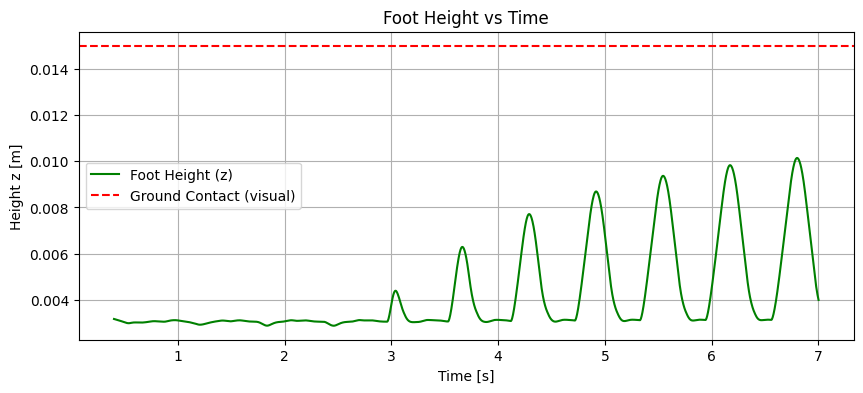

Cell 6: Plotted the vertical position of the foot over time and marked an approximate ground-contact height for gait analysis.


In [27]:
# @title 6. Plot Foot (End-Effector) Height vs Time

plt.figure(figsize=(10, 4))
plt.plot(times, z_positions, label="Foot Height (z)", color="green")
plt.axhline(y=0.015, color='r', linestyle='--', label="Ground Contact (visual)")
plt.xlabel("Time [s]")
plt.ylabel("Height z [m]")
plt.title("Foot Height vs Time")
plt.grid(True)
plt.legend()
plt.show()
print("Cell 6: Plotted the vertical position of the foot over time and marked an approximate ground-contact height for gait analysis.")

Cell 7: Plotted the estimated forward velocity of the foot/end-effector as a function of time to visualize locomotion speed.


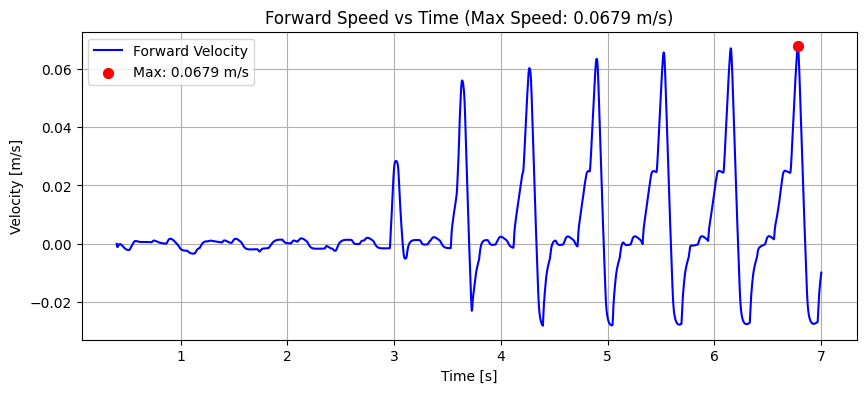

In [28]:
# @title 7. Plot Forward Velocity vs Time
print("Cell 7: Plotted the estimated forward velocity of the foot/end-effector as a function of time to visualize locomotion speed.")

# --- ADDED CODE START ---
# 1. Find maximum velocity
max_velocity = max(velocities)

# 2. Find the index where max velocity occurred to get the corresponding time
# Note: If using numpy arrays, use: max_index = np.argmax(velocities)
max_index = velocities.index(max_velocity)
time_of_max = times[max_index]
# --- ADDED CODE END ---


plt.figure(figsize=(10, 4))
plt.plot(times, velocities, label="Forward Velocity", color="blue")

# --- ADDED CODE START ---
# 3. Plot a red dot at the maximum point
# We plot a single point (scatter plot) at [time_of_max, max_velocity]
plt.scatter([time_of_max], [max_velocity], color="red", s=50, label=f"Max: {max_velocity:.4f} m/s", zorder=5)
# (s=50 controls dot size, zorder=5 ensures it sits on top of the blue line)
# --- ADDED CODE END ---

plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")

# --- MODIFIED LINE ---
# Update title to include the max value formatted to 2 decimal places
plt.title(f"Forward Speed vs Time (Max Speed: {max_velocity:.4f} m/s)")
# ---------------------

plt.grid(True)
plt.legend()
plt.show()

Cell 8: Plotted potential, kinetic, and total mechanical energy over time to inspect energy behavior and stability of the gait.
Simulation started...
Simulation complete. Peak Kinetic Energy: 0.0164 J


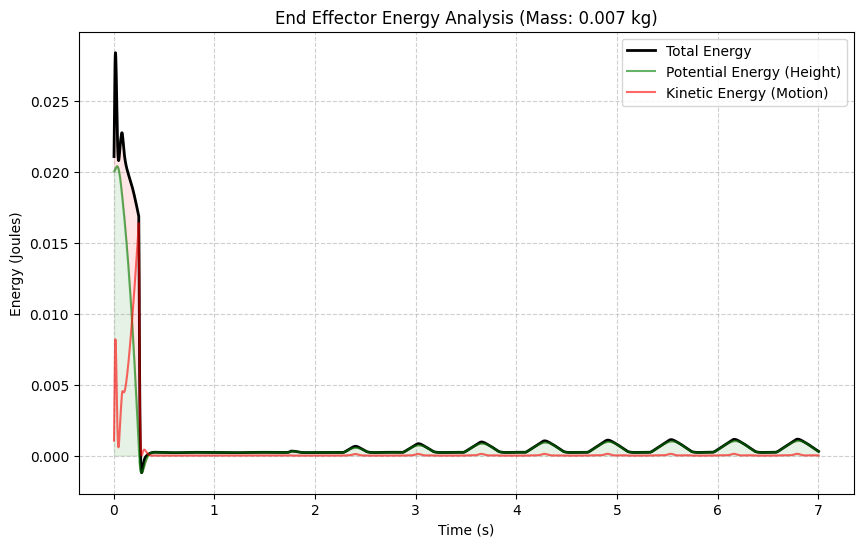

In [29]:
# @title 8. Calculate and Plot End-Effector Energy (Fixed)
print("Cell 8: Plotted potential, kinetic, and total mechanical energy over time to inspect energy behavior and stability of the gait.")
# --- 1. RESET SIMULATION ---
mujoco.mj_resetData(model, data) # <--- THIS FIXES THE ERROR
data.qpos[qA2_adr] = np.deg2rad(start_angle_A2) # Reset initial angles
data.qpos[qB1_adr] = np.deg2rad(start_angle_B1)

# --- SETUP ---
frames = []
green_tip_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, 'green_tip')
foot_body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, 'A32')
renderer = mujoco.Renderer(model, height=480, width=640)

# Get Mass of the foot link
foot_mass = model.body_mass[foot_body_id]
gravity = 9.81

# Data containers
times = []
ke_history = []  # Kinetic Energy
pe_history = []  # Potential Energy
total_e_history = [] # Total Energy

prev_pos = None

print("Simulation started...")

# --- SIMULATION LOOP ---
while data.time < duration:
    # 1. Targets
    target_A2_deg = mid_A2 + amp_A2 * np.cos(speed * data.time)
    target_B1_deg = mid_B1 + amp_B1 * np.cos(speed * data.time + phase_offset)

    # 2. Current State
    curr_qA2 = data.qpos[qA2_adr]
    curr_wA2 = data.qvel[dofA2_adr]
    curr_qB1 = data.qpos[qB1_adr]
    curr_wB1 = data.qvel[dofB1_adr]

    # 3. Control
    torque_A = calculate_real_torque(curr_qA2, curr_wA2, np.deg2rad(target_A2_deg))
    torque_B = calculate_real_torque(curr_qB1, curr_wB1, np.deg2rad(target_B1_deg))

    data.ctrl[0] = torque_A
    data.ctrl[1] = torque_B

    mujoco.mj_step(model, data)

    # 4. Energy Calculation
    current_pos = data.site_xpos[green_tip_id].copy()

    if prev_pos is not None:
        dt = 0.002
        velocity_vector = (current_pos - prev_pos) / dt
        velocity_mag = np.linalg.norm(velocity_vector)

        # Kinetic Energy: 1/2 * m * v^2
        ke = 0.5 * foot_mass * (velocity_mag ** 2)

        # Potential Energy: m * g * h
        pe = foot_mass * gravity * current_pos[2]

        ke_history.append(ke)
        pe_history.append(pe)
        total_e_history.append(ke + pe)
        times.append(data.time)

    prev_pos = current_pos

    # Render
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, camera="track_cam")
        frames.append(renderer.render())

# --- PLOTTING ---
if len(ke_history) > 0:
    print(f"Simulation complete. Peak Kinetic Energy: {max(ke_history):.4f} J")

    plt.figure(figsize=(10, 6))
    plt.plot(times, total_e_history, color='black', linewidth=2, label='Total Energy')
    plt.plot(times, pe_history, color='green', alpha=0.6, label='Potential Energy (Height)')
    plt.plot(times, ke_history, color='red', alpha=0.6, label='Kinetic Energy (Motion)')

    plt.fill_between(times, pe_history, color='green', alpha=0.1)
    plt.fill_between(times, pe_history, total_e_history, color='red', alpha=0.1)

    plt.title(f"End Effector Energy Analysis (Mass: {foot_mass:.3f} kg)")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (Joules)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

else:
    print("Error: No data recorded. Check if simulation duration > 0.")

In [30]:
# @title 2. Define Simulation Parameters and Motor Model
print("Cell 2: Defined all gait parameters and implemented a DC-motor-based torque model used to drive the joints.")
# --- GAIT / MOTION CONFIGURATION ---
start_angle_A2 = -80
end_angle_A2   = -160

start_angle_B1 = -70
end_angle_B1   = -130

duration    = 7.0      # total simulation time [s]
framerate   = 60       # video FPS
speed       = 10.0     # oscillation speed
phase_offset = 3.14    # phase offset between the two legs [rad] (4 different value: pi/2 for first 2 observations, pi/4, 3pi/4, pi)

# Sinusoid midpoints and amplitudes (deg)
mid_A2 = (start_angle_A2 + end_angle_A2) / 2
amp_A2 = (start_angle_A2 - end_angle_A2) / 2

mid_B1 = (start_angle_B1 + end_angle_B1) / 2
amp_B1 = (start_angle_B1 - end_angle_B1) / 2

# Threshold for detecting foot-ground contact (for gait analysis)
contact_threshold = 0.02  # [m]


# --- MOTOR / SERVO PHYSICS (simple DC motor model) ---
Vnom          = 6.0      # nominal motor voltage [V]
G             = 55.5     # gear ratio
i_stall       = 0.6      # stall current [A]
t_stall_motor = 0.15     # stall torque at motor shaft [Nm]
w_nl_deg      = 0.66 * 1000  # no-load speed [deg/s]

R    = Vnom / i_stall                 # winding resistance [Ohm]
w_nl = w_nl_deg * (np.pi / 180.0)     # no-load speed [rad/s]
kt   = t_stall_motor / i_stall        # torque constant [Nm/A]
ke   = kt                             # back-EMF constant (SI)
b_motor = (kt * i_stall) / (w_nl * G) # viscous friction (approx)
V_supply = 12.0                       # supply voltage [V]
kp_motor = 50.0                       # position gain for servo control


def calculate_real_torque(current_q, current_vel, desired_q):
    """DC motor model with simple position control -> joint torque."""
    error = desired_q - current_q
    V = kp_motor * error

    # Saturate voltage to supply
    if V > V_supply:
        V = V_supply
    if V < -V_supply:
        V = -V_supply

    # Motor-side angular velocity
    w_motor = current_vel * G

    # Motor current from electrical model
    current = (V - (ke * w_motor)) / R

    # Motor shaft torque with viscous losses
    torque_motor = (kt * current) - (b_motor * w_motor)

    # Return joint torque after gearbox
    return torque_motor * G


Cell 2: Defined all gait parameters and implemented a DC-motor-based torque model used to drive the joints.


In [31]:
# @title 3. Xml Model
print("Cell 3: Defined the full MuJoCo MJCF model (rigid body, legs, foot, loop constraint, and camera) as an XML string.")
mjcf_xml = """
<mujoco model="5_bar_pendulum_scaled">
  <option timestep="0.002" gravity="0 0 -9.81" integrator="RK4" solver="Newton" iterations="100" tolerance="1e-4"/>

  <visual>
    <global offwidth="640" offheight="480"/>
    <rgba haze="1 1 1 1"/> <headlight active="1" diffuse="0.8 0.8 0.8"/>
  </visual>

  <asset>
     <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".8 .9 .9"/>
     <material name="grid_mat" texture="grid" texrepeat="1 1" texuniform="true" reflectance=".2"/>
  </asset>

  <default>
    <geom type="capsule" size="0.005" density="1000"/>
    <joint damping="5.0" armature="0.2"/>
  </default>

  <worldbody>
    <geom name="floor" type="plane" size="5 1 0.1" material="grid_mat" friction="2.0 0.005 0.0001"/>

    <body name="Rig" pos="0 0 0.5">
      <joint name="x_rail" type="slide" axis="1 0 0" damping="0.5"/>
      <joint name="z_bounce" type="slide" axis="0 0 1" damping="2.0" stiffness="0"/>

      <geom type="box" pos="0.15625 0 0" size="0.15625 0.01 0.01" rgba="0.2 0.2 0.2 1" mass="3"/>

      <geom name="stand_rear" type="capsule" fromto="0 0 0 0 0 -0.1875" size="0.01" rgba="0.5 0.5 0.5 0.3" friction="0 0 0"/>
      <geom name="stand_front" type="capsule" fromto="0.15625 0 0 0.15625 0 -0.1875" size="0.01" rgba="0.5 0.5 0.5 0.3" friction="0 0 0"/>

      <body name="A2" pos="0.25 0 0" euler="180 0 0">
        <joint name="qA2" axis="0 1 0"/>
        <geom fromto="0 0 0 0.0625 0 0" rgba="0.2 0.2 0.8 1"/>
        <body name="B2" pos="0.0625 0 0">
          <joint name="qB2" axis="0 1 0"/>
          <geom fromto="0 0 0 0.0625 0 0" rgba="0.2 0.8 0.8 1"/>
          <site name="s_B2_tip" pos="0.0625 0 0" size="0.005" rgba="0 0 0 0"/>
          <geom fromto="0.0625 0 0 0.1291 0 0" rgba="0 0.8 0 1"/>
          <body name="A32" pos="0.1291 0 0">
              <joint name="qA32" axis="0 1 0" stiffness="500" damping="10"/>
              <geom fromto="0 0 0 0.0333 0 0" rgba="0 1 0 1"/>
              <geom name="foot" type="sphere" pos="0.0333 0 0" size="0.01" friction="100"/>
              <site name="green_tip" pos="0.0333 0 0" size="0.008" rgba="1 0 0 1"/>
          </body>
        </body>
      </body>

      <body name="B1" pos="0.3125 0 0" euler="180 0 0">
        <joint name="qB1" axis="0 1 0"/>
        <geom fromto="0 0 0 0.0625 0 0" rgba="0.8 0.2 0.2 1"/>
        <body name="C1" pos="0.0625 0 0">
          <joint name="qC1" axis="0 1 0"/>
          <geom fromto="0 0 0 0.0625 0 0" rgba="0.8 0.2 0.8 1"/>
          <site name="s_C1_tip" pos="0.0625 0 0" size="0.005" rgba="0 0 0 0"/>
        </body>
      </body>
    </body>

    <camera name="track_cam" mode="track" target="Rig" pos="0.3 -1.5 0.5" xyaxes="1 0 0 0 0 1"/>
  </worldbody>

  <equality>
    <connect name="loop_closure" site1="s_B2_tip" site2="s_C1_tip"/>
  </equality>

  <actuator>
    <motor name="servo_A2" joint="qA2" gear="1"/>
    <motor name="servo_B1" joint="qB1" gear="1"/>
  </actuator>

</mujoco>"""

Cell 3: Defined the full MuJoCo MJCF model (rigid body, legs, foot, loop constraint, and camera) as an XML string.


In [32]:
# @title 4. Run Simulation and Generate Video Frames
print("Cell 4: Built the model, ran warmup + main simulation, logged kinematics and energy, rendered frames, computed gait stats, and saved frames to a video file.")
# Build model and data
model = mujoco.MjModel.from_xml_string(mjcf_xml)
data = mujoco.MjData(model)
mujoco.mj_resetData(model, data)

# Simulation timestep from model
dt = model.opt.timestep

# Joint indices / addresses
qA2_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'qA2')
qB1_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, 'qB1')

qA2_adr   = model.jnt_qposadr[qA2_id]
qB1_adr   = model.jnt_qposadr[qB1_id]
dofA2_adr = model.jnt_dofadr[qA2_id]
dofB1_adr = model.jnt_dofadr[qB1_id]

# Initial joint configuration
data.qpos[qA2_adr] = np.deg2rad(start_angle_A2)
data.qpos[qB1_adr] = np.deg2rad(start_angle_B1)

# --- WARMUP / SETTLING PHASE ---
print("Settling physics (Warmup)...")
for _ in range(200):
    curr_qA2 = data.qpos[qA2_adr]
    curr_wA2 = data.qvel[dofA2_adr]
    trq_A = calculate_real_torque(curr_qA2, curr_wA2, np.deg2rad(start_angle_A2))

    curr_qB1 = data.qpos[qB1_adr]
    curr_wB1 = data.qvel[dofB1_adr]
    trq_B = calculate_real_torque(curr_qB1, curr_wB1, np.deg2rad(start_angle_B1))

    data.ctrl[0] = trq_A
    data.ctrl[1] = trq_B
    mujoco.mj_step(model, data)

data.qvel[:] = 0.0
print("Physics settled. Starting simulation...")

# --- PREPARE LOGGING & RENDERING ---
green_tip_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, 'green_tip')
renderer = mujoco.Renderer(model, height=480, width=640)

times        = []
x_positions  = []
z_positions  = []
velocities   = []

energy_potential = []   # potential energy
energy_kinetic   = []   # kinetic energy
energy_total     = []   # total mechanical energy

frames = []

# --- MAIN SIMULATION LOOP ---
while data.time < duration:
    # Oscillatory target angles (deg)
    target_A2_deg = mid_A2 + amp_A2 * np.cos(speed * data.time)
    target_B1_deg = mid_B1 + amp_B1 * np.cos(speed * data.time + phase_offset)

    # Convert to radians
    target_A2 = np.deg2rad(target_A2_deg)
    target_B1 = np.deg2rad(target_B1_deg)

    # Current state
    curr_qA2 = data.qpos[qA2_adr]
    curr_wA2 = data.qvel[dofA2_adr]
    curr_qB1 = data.qpos[qB1_adr]
    curr_wB1 = data.qvel[dofB1_adr]

    # Motor torques
    torque_A = calculate_real_torque(curr_qA2, curr_wA2, target_A2)
    torque_B = calculate_real_torque(curr_qB1, curr_wB1, target_B1)

    data.ctrl[0] = torque_A
    data.ctrl[1] = torque_B

    # Advance physics
    mujoco.mj_step(model, data)

    # --- KINEMATICS LOGGING (end-effector) ---
    pos = data.site_xpos[green_tip_id]  # [x, y, z] of green_tip
    if len(x_positions) > 0:
        vel = (pos[0] - x_positions[-1]) / dt
    else:
        vel = 0.0

    times.append(data.time)
    x_positions.append(pos[0])
    z_positions.append(pos[2])
    velocities.append(vel)

    # --- ENERGY LOGGING ---
    # Compute potential and kinetic energy into data.energy[0], data.energy[1]
    mujoco.mj_energyPos(model, data)
    mujoco.mj_energyVel(model, data)
    energy_potential.append(float(data.energy[0]))            # potential
    energy_kinetic.append(float(data.energy[1]))              # kinetic
    energy_total.append(float(data.energy[0] + data.energy[1]))  # total

    # --- RENDER VIDEO FRAMES ---
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, camera="track_cam")
        frames.append(renderer.render())

print(f"Simulation complete. Generated {len(frames)} frames and {len(times)} time samples.")

# --- GAIT STATS (STRIDE LENGTH) ---
contacts = []
for i in range(1, len(z_positions)):
    if z_positions[i-1] > contact_threshold and z_positions[i] <= contact_threshold:
        contacts.append(i)

print("\n--- GAIT ANALYSIS ---")
if len(contacts) > 1:
    total_dist = 0.0
    for i in range(len(contacts) - 1):
        idx_now  = contacts[i]
        idx_next = contacts[i+1]
        stride_len = x_positions[idx_next] - x_positions[idx_now]
        print(f"Stride {i+1}: Length = {stride_len:.3f} m")
        total_dist += stride_len
    print(f"Average Stride Length: {total_dist / (len(contacts) - 1):.3f} m")
else:
    print("Not enough contacts detected to compute stride length.")




Cell 4: Built the model, ran warmup + main simulation, logged kinematics and energy, rendered frames, computed gait stats, and saved frames to a video file.
Settling physics (Warmup)...
Physics settled. Starting simulation...
Simulation complete. Generated 421 frames and 3301 time samples.

--- GAIT ANALYSIS ---
Not enough contacts detected to compute stride length.


In [33]:
# @title 5. Display Video
# Inline playback in notebook
print("Cell 5: Displayed the simulation video inline in the notebook.")
media.show_video(frames, fps=framerate)


Cell 5: Displayed the simulation video inline in the notebook.


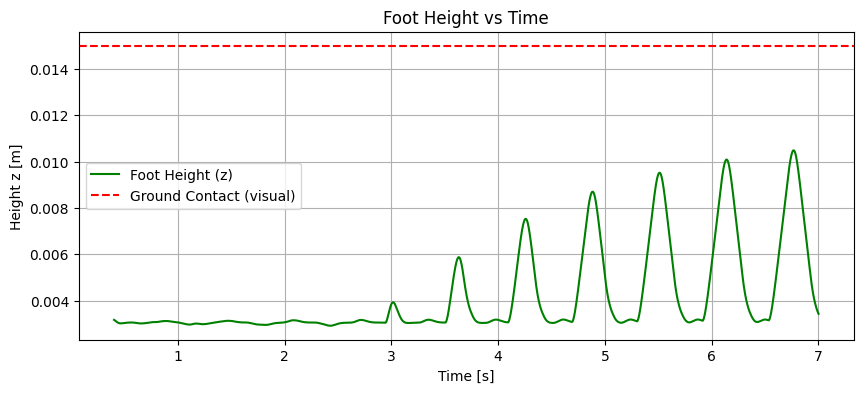

Cell 6: Plotted the vertical position of the foot over time and marked an approximate ground-contact height for gait analysis.


In [34]:
# @title 6. Plot Foot (End-Effector) Height vs Time

plt.figure(figsize=(10, 4))
plt.plot(times, z_positions, label="Foot Height (z)", color="green")
plt.axhline(y=0.015, color='r', linestyle='--', label="Ground Contact (visual)")
plt.xlabel("Time [s]")
plt.ylabel("Height z [m]")
plt.title("Foot Height vs Time")
plt.grid(True)
plt.legend()
plt.show()
print("Cell 6: Plotted the vertical position of the foot over time and marked an approximate ground-contact height for gait analysis.")

Cell 7: Plotted the estimated forward velocity of the foot/end-effector as a function of time to visualize locomotion speed.


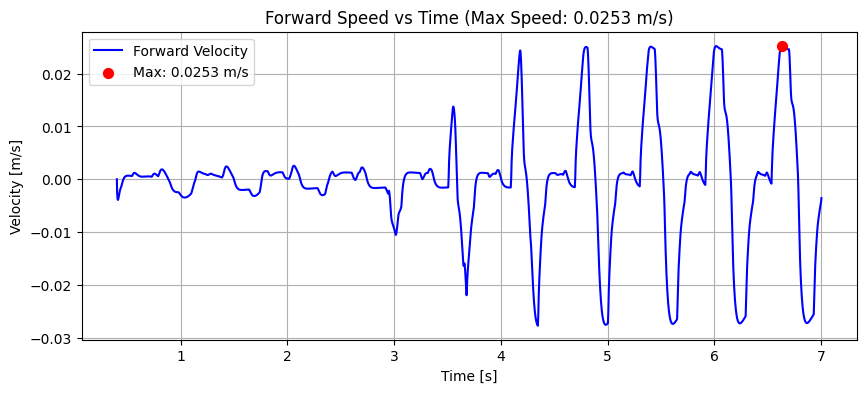

In [35]:
# @title 7. Plot Forward Velocity vs Time
print("Cell 7: Plotted the estimated forward velocity of the foot/end-effector as a function of time to visualize locomotion speed.")

# --- ADDED CODE START ---
# 1. Find maximum velocity
max_velocity = max(velocities)

# 2. Find the index where max velocity occurred to get the corresponding time
# Note: If using numpy arrays, use: max_index = np.argmax(velocities)
max_index = velocities.index(max_velocity)
time_of_max = times[max_index]
# --- ADDED CODE END ---


plt.figure(figsize=(10, 4))
plt.plot(times, velocities, label="Forward Velocity", color="blue")

# --- ADDED CODE START ---
# 3. Plot a red dot at the maximum point
# We plot a single point (scatter plot) at [time_of_max, max_velocity]
plt.scatter([time_of_max], [max_velocity], color="red", s=50, label=f"Max: {max_velocity:.4f} m/s", zorder=5)
# (s=50 controls dot size, zorder=5 ensures it sits on top of the blue line)
# --- ADDED CODE END ---

plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")

# --- MODIFIED LINE ---
# Update title to include the max value formatted to 2 decimal places
plt.title(f"Forward Speed vs Time (Max Speed: {max_velocity:.4f} m/s)")
# ---------------------

plt.grid(True)
plt.legend()
plt.show()

Cell 8: Plotted potential, kinetic, and total mechanical energy over time to inspect energy behavior and stability of the gait.
Simulation started...
Simulation complete. Peak Kinetic Energy: 0.0166 J


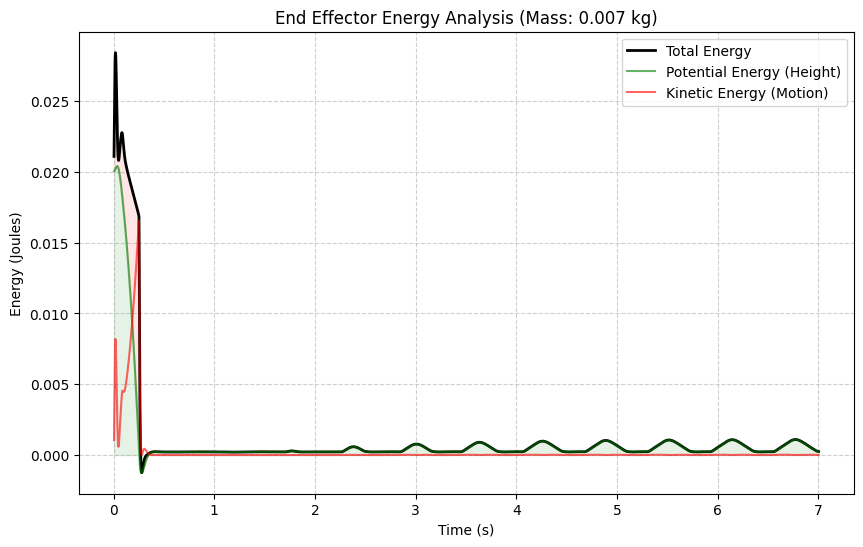

In [36]:
# @title 8. Calculate and Plot End-Effector Energy (Fixed)
print("Cell 8: Plotted potential, kinetic, and total mechanical energy over time to inspect energy behavior and stability of the gait.")
# --- 1. RESET SIMULATION ---
mujoco.mj_resetData(model, data) # <--- THIS FIXES THE ERROR
data.qpos[qA2_adr] = np.deg2rad(start_angle_A2) # Reset initial angles
data.qpos[qB1_adr] = np.deg2rad(start_angle_B1)

# --- SETUP ---
frames = []
green_tip_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, 'green_tip')
foot_body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, 'A32')
renderer = mujoco.Renderer(model, height=480, width=640)

# Get Mass of the foot link
foot_mass = model.body_mass[foot_body_id]
gravity = 9.81

# Data containers
times = []
ke_history = []  # Kinetic Energy
pe_history = []  # Potential Energy
total_e_history = [] # Total Energy

prev_pos = None

print("Simulation started...")

# --- SIMULATION LOOP ---
while data.time < duration:
    # 1. Targets
    target_A2_deg = mid_A2 + amp_A2 * np.cos(speed * data.time)
    target_B1_deg = mid_B1 + amp_B1 * np.cos(speed * data.time + phase_offset)

    # 2. Current State
    curr_qA2 = data.qpos[qA2_adr]
    curr_wA2 = data.qvel[dofA2_adr]
    curr_qB1 = data.qpos[qB1_adr]
    curr_wB1 = data.qvel[dofB1_adr]

    # 3. Control
    torque_A = calculate_real_torque(curr_qA2, curr_wA2, np.deg2rad(target_A2_deg))
    torque_B = calculate_real_torque(curr_qB1, curr_wB1, np.deg2rad(target_B1_deg))

    data.ctrl[0] = torque_A
    data.ctrl[1] = torque_B

    mujoco.mj_step(model, data)

    # 4. Energy Calculation
    current_pos = data.site_xpos[green_tip_id].copy()

    if prev_pos is not None:
        dt = 0.002
        velocity_vector = (current_pos - prev_pos) / dt
        velocity_mag = np.linalg.norm(velocity_vector)

        # Kinetic Energy: 1/2 * m * v^2
        ke = 0.5 * foot_mass * (velocity_mag ** 2)

        # Potential Energy: m * g * h
        pe = foot_mass * gravity * current_pos[2]

        ke_history.append(ke)
        pe_history.append(pe)
        total_e_history.append(ke + pe)
        times.append(data.time)

    prev_pos = current_pos

    # Render
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, camera="track_cam")
        frames.append(renderer.render())

# --- PLOTTING ---
if len(ke_history) > 0:
    print(f"Simulation complete. Peak Kinetic Energy: {max(ke_history):.4f} J")

    plt.figure(figsize=(10, 6))
    plt.plot(times, total_e_history, color='black', linewidth=2, label='Total Energy')
    plt.plot(times, pe_history, color='green', alpha=0.6, label='Potential Energy (Height)')
    plt.plot(times, ke_history, color='red', alpha=0.6, label='Kinetic Energy (Motion)')

    plt.fill_between(times, pe_history, color='green', alpha=0.1)
    plt.fill_between(times, pe_history, total_e_history, color='red', alpha=0.1)

    plt.title(f"End Effector Energy Analysis (Mass: {foot_mass:.3f} kg)")
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (Joules)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

else:
    print("Error: No data recorded. Check if simulation duration > 0.")